## Name: Mourad Askar
### Course: CSC-578
### Class Project: Time Series

# Time series forecasting

The goal in this project is to build **multi-step RNN with LSTM model** that makes a prediction of the traffic **volume** **2h into the future [shift]**, given **6h of history [input window]**.

## Setup

In [1]:
from google.colab import drive, files

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.grid'] = False

np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

%config InlineBackend.figure_format = 'retina'

p_version = lambda x: print(x.__package__, x.__version__)

p_version(tf)  # check the TF version!

tensorflow 2.5.0


In [2]:
!nvidia-smi  # Check the GPU specs provided for this instance

Wed Jun  9 04:44:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#drive.mount('/content/gdrive')
#files.upload()
#files.view('/content')
#files.download('/content/test.txt')

## The Metro Interstate dataset
This project uses the <a href="https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume" class="external">Metro Interstate Traffic Volume Data Set</a>. Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

There are 48,204 total instances, with 9 features:

> **[0] holiday:** string (None or name of holiday).  
**[1] temp:** in degrees kelvin.  
**[2] rain_1h:** in mm for the last hour.  
**[3] snow_1h:** in mm for the last hour.  
**[4] clouds:** percent.  
**[5] weather_main:** short descriptive text.  
**[6] weather_description:** longer descriptive.   text   
**[7] date_time:** in Y/m/d H:M:S format. (FIXED)  
**[8] traffic_volume:** # of cars in the last hour.  

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz',
    fname='Metro_Interstate_Traffic_Volume.csv.gz',
    cache_dir='/content', cache_subdir='data')
# gunzip the downloaded file
!gunzip -f data/Metro_Interstate_Traffic_Volume.csv.gz
csv_path, _ = os.path.splitext(zip_path) # just strip off the .gz
csv_path # should be '/content/data/Metro_Interstate_Traffic_Volume.csv'

409600/405373 [==============================] - 0s 0us/step


'/content/data/Metro_Interstate_Traffic_Volume.csv'

We will deal with **hourly predictions**, and the data is expected to be captured at 1 hour intervals:

In [5]:
df_raw = pd.read_csv(csv_path, parse_dates=['date_time'], index_col='date_time')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [6]:
df_raw.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.00,48204.00,48204.00,48204.00,48204.00
mean,281.21,0.33,0.00,49.36,3259.82
std,13.34,44.79,0.01,39.02,1986.86
min,0.00,0.00,0.00,0.00,0.00
25%,272.16,0.00,0.00,1.00,1193.00
50%,282.45,0.00,0.00,64.00,3380.00
75%,291.81,0.00,0.00,90.00,4933.00
max,310.07,9831.30,0.51,100.00,7280.00


Let's take a glance at the data. Here are the first and last few rows:

In [7]:
df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.00,0.00,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.00,0.00,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.00,0.00,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.00,0.00,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.00,0.00,75,Clouds,broken clouds,4918
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.00,0.00,75,Clouds,broken clouds,3543
2018-09-30 20:00:00,None,282.76,0.00,0.00,90,Clouds,overcast clouds,2781
2018-09-30 21:00:00,None,282.73,0.00,0.00,90,Thunderstorm,proximity thunderstorm,2159


Let's check for missing fields.
* No missing field values.

In [8]:
df_raw.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
traffic_volume         0
dtype: int64

### Data Overview

In [9]:
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all','traffic_volume']

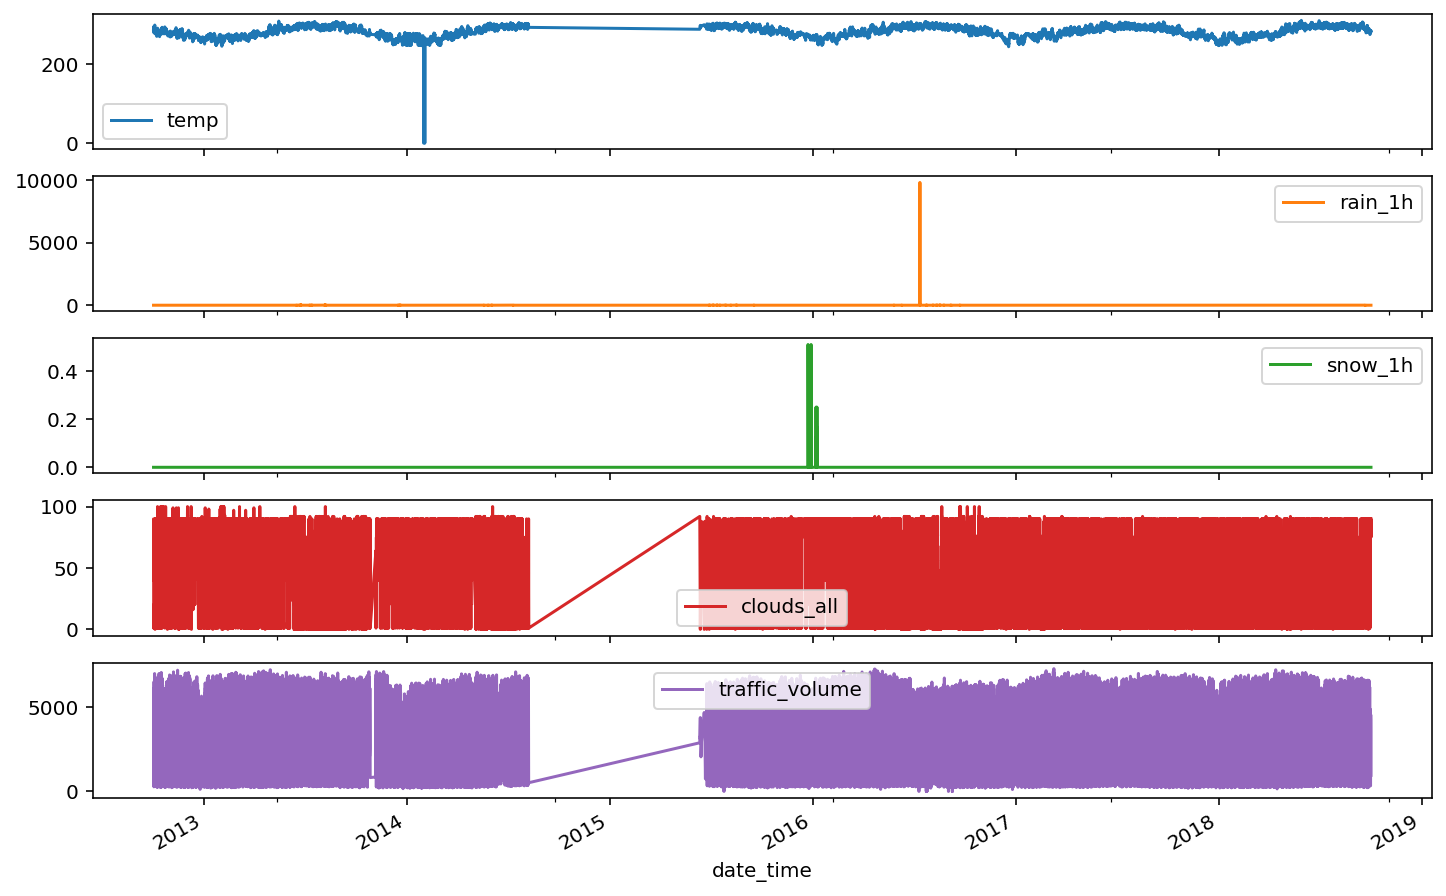

In [10]:
plot_features = df_raw[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2013-10-01 21:00:00,285.52,0.00,0.00,0,2670
2013-10-01 23:00:00,282.93,0.00,0.00,0,1299
2013-10-02 23:00:00,286.63,2.37,0.00,88,899
2013-10-02 23:00:00,286.63,2.37,0.00,88,899
2013-10-02 23:00:00,286.63,2.37,0.00,88,899
...,...,...,...,...,...
2013-11-30 19:00:00,274.27,0.00,0.00,64,3532
2013-11-30 20:00:00,273.16,0.00,0.00,64,2896
2013-11-30 21:00:00,272.51,0.00,0.00,64,2603


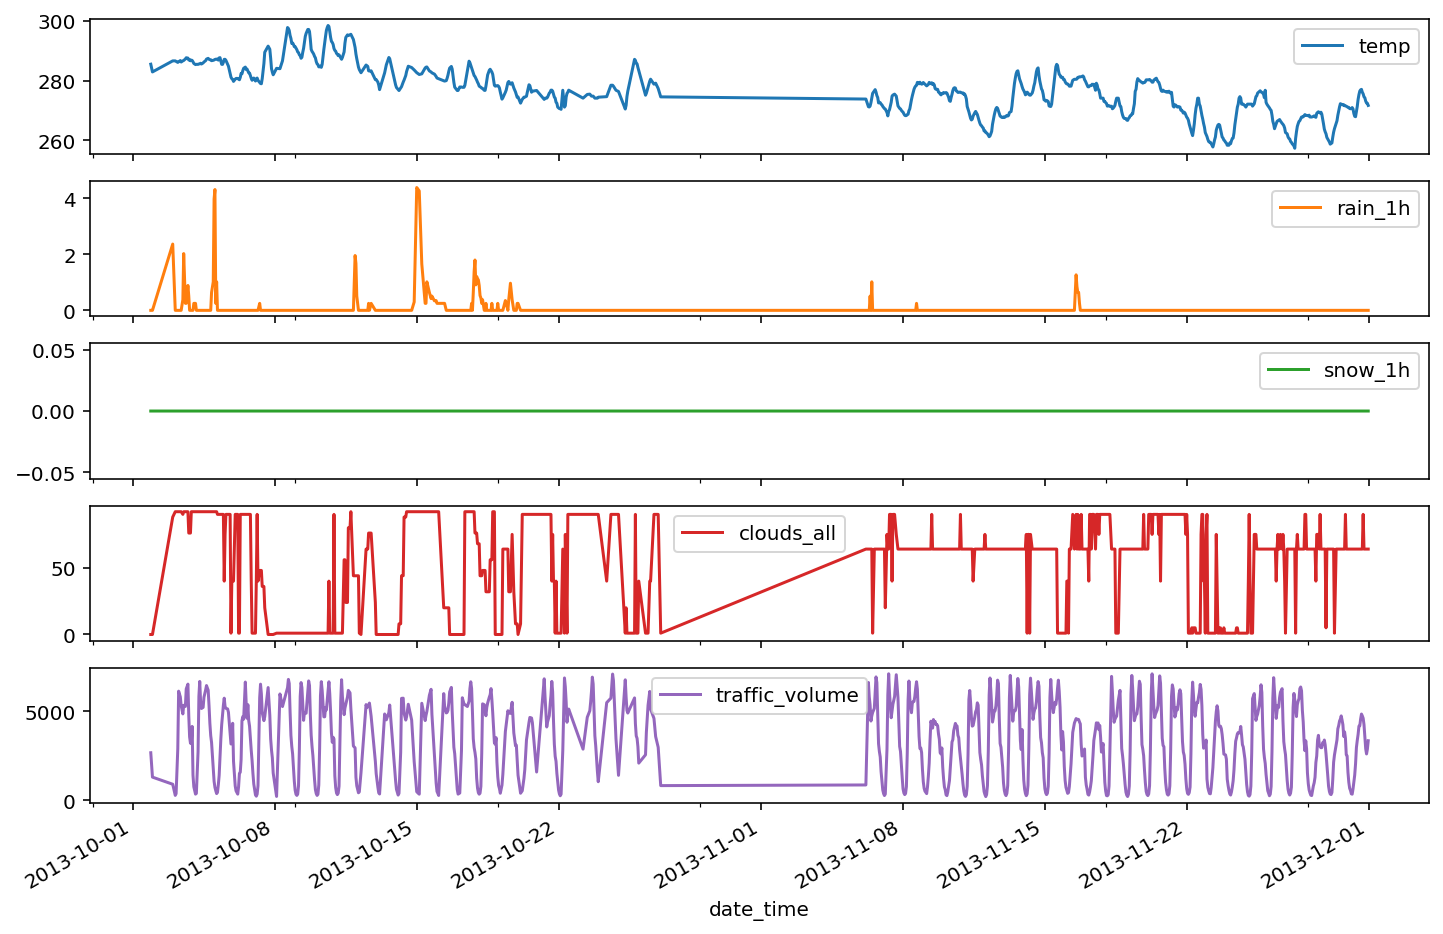

In [11]:
plot_features = df_raw[plot_cols]['2013-10':'2013-11']
display(plot_features)
_ = plot_features.plot(subplots=True, figsize=(12,8))

Data is missing records between 2013-10 and 2013-11

and data is missing records between 2014-08-08  and 2015-06-11


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-08-08 00:00:00,None,293.45,0.00,0.00,40,Clouds,scattered clouds,848
2014-08-08 01:00:00,None,292.38,0.00,0.00,1,Clear,sky is clear,516
2015-06-11 20:00:00,None,287.59,0.00,0.00,92,Rain,light rain,2886


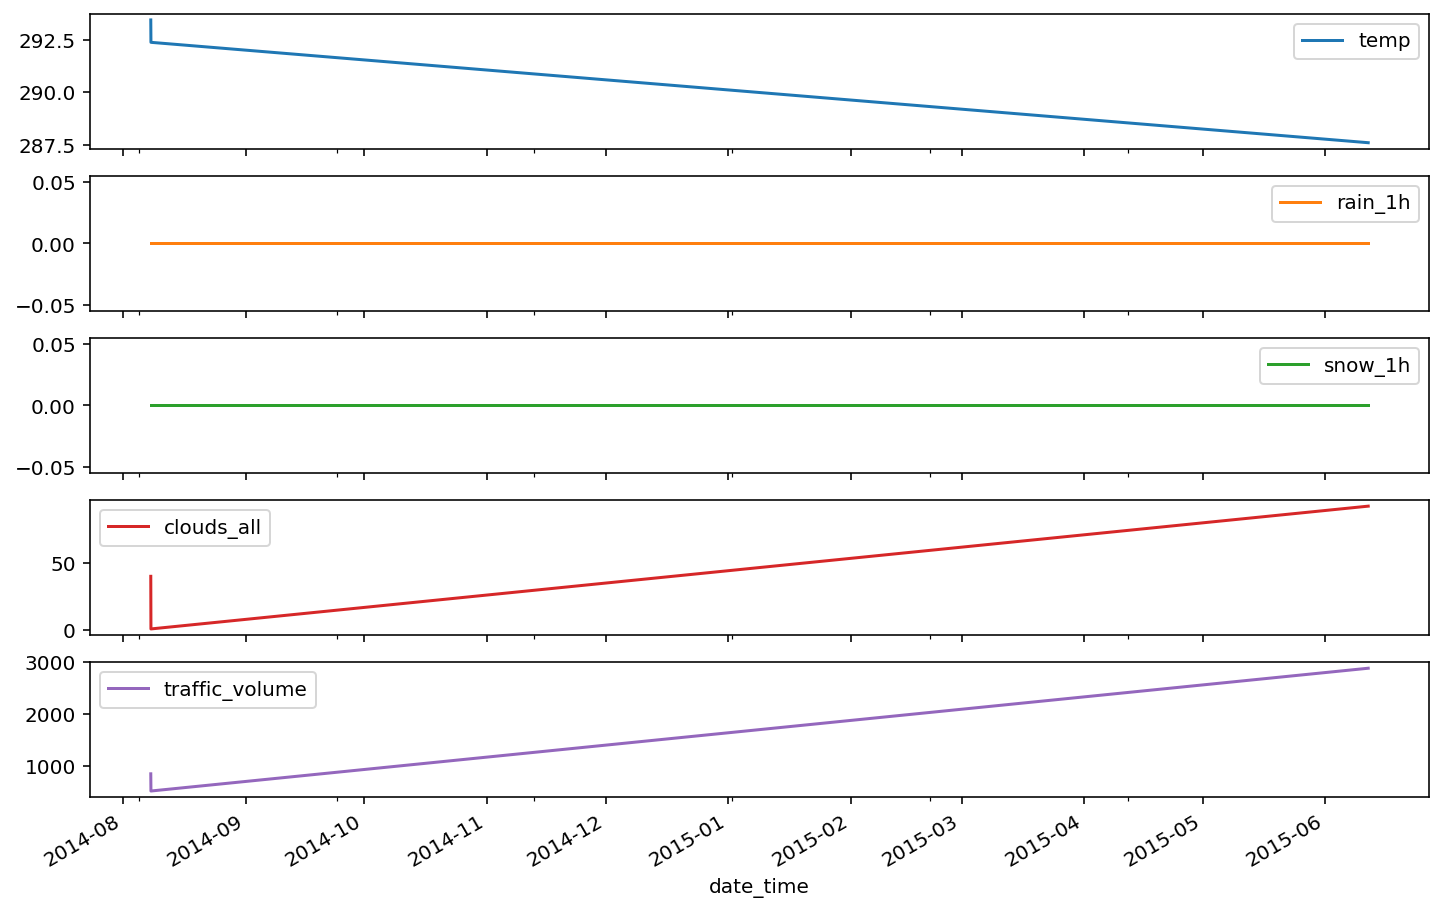

In [12]:
plot_features = df_raw['2014-08-08':'2015-06-11']
display(plot_features)
_ = plot_features.plot(subplots=True, figsize=(12,8))

### Inspect and cleanup

Next look at the statistics of the dataset:

In [13]:
df_raw.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
temp,48204.00,281.21,13.34,0.00,272.16,282.45,291.81,310.07
rain_1h,48204.00,0.33,44.79,0.00,0.00,0.00,0.00,9831.30
snow_1h,48204.00,0.00,0.01,0.00,0.00,0.00,0.00,0.51
clouds_all,48204.00,49.36,39.02,0.00,1.00,64.00,90.00,100.00
traffic_volume,48204.00,3259.82,1986.86,0.00,1193.00,3380.00,4933.00,7280.00


In [14]:
df_raw.describe(include='object').transpose()

,count,unique,top,freq
holiday,48204,12,None,48143
weather_main,48204,11,Clouds,15164
weather_description,48204,38,sky is clear,11665


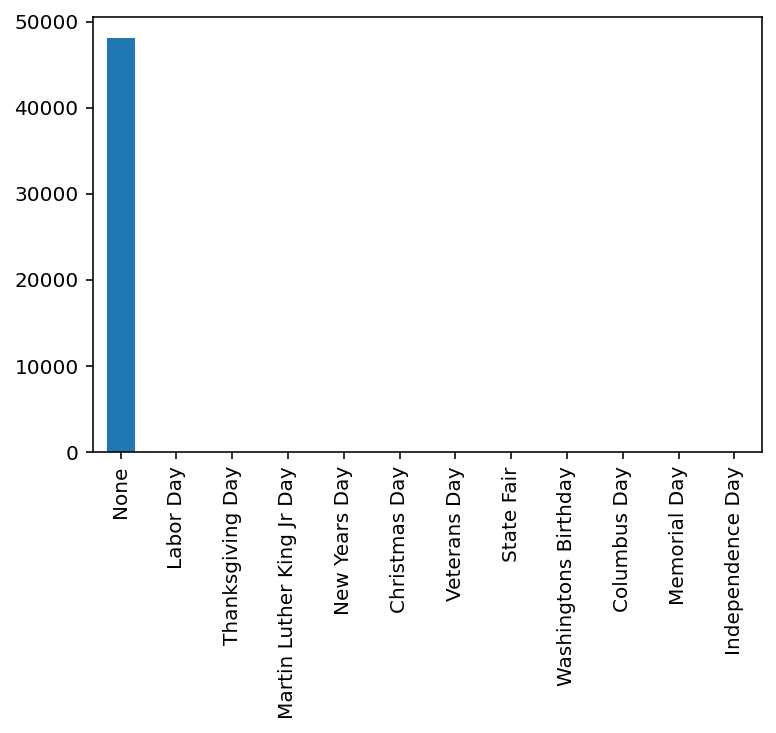

In [15]:
df_raw.holiday.value_counts().plot.bar();

Let's see the distribution without the None values

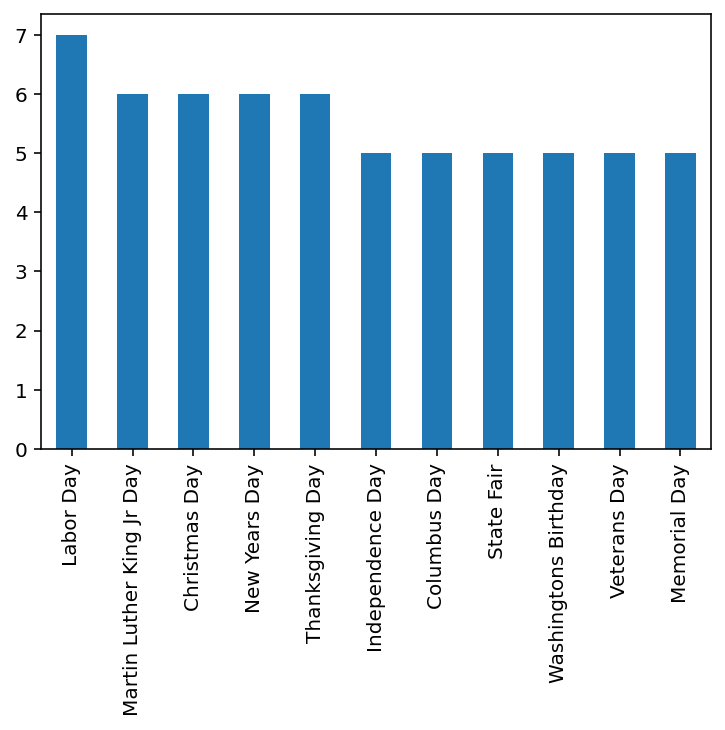

In [16]:
df_raw[df_raw.holiday != 'None'].holiday.value_counts().plot.bar();

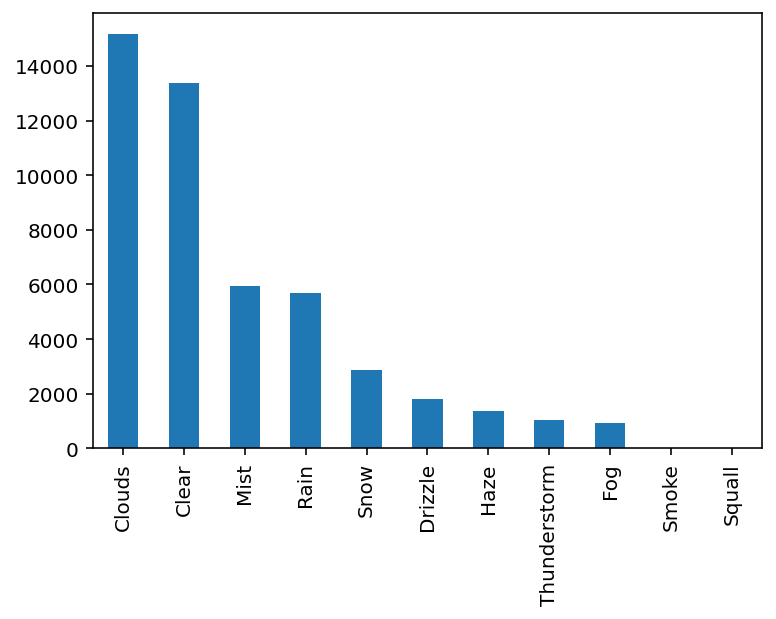

In [17]:
df_raw.weather_main.value_counts().plot.bar();

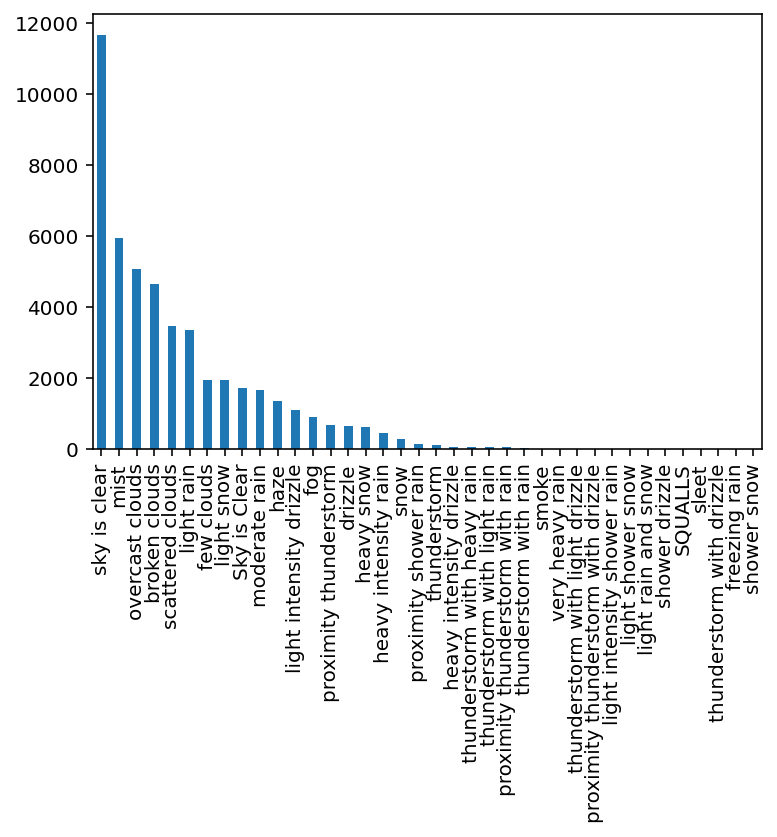

In [18]:
df_raw.weather_description.value_counts().plot.bar();

#### Temperature

Temerature values of 0 seem to be erronoes so we will replace with the mean value of the day. We observe 2 days having erronous values [2014-01-31, 2014-02-02]

In [19]:
df_raw[df_raw.temp == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,361
2014-01-31 04:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,734
2014-01-31 05:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,2557
2014-01-31 06:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,5150
2014-02-02 03:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,291
2014-02-02 04:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,284
2014-02-02 05:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,434
2014-02-02 06:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,739
2014-02-02 07:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,962


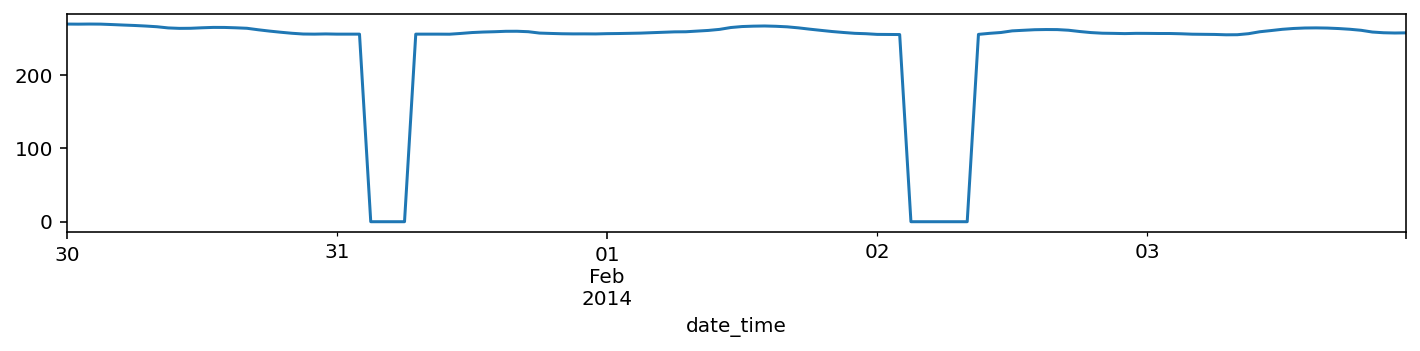

In [20]:
plot_features = df_raw['temp']['2014-01-30':'2014-02-03']
_ = plot_features.plot(figsize=(12,2))

In [21]:
df_raw['2014-01-31']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 00:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,644
2014-01-31 01:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,390
2014-01-31 02:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,313
2014-01-31 03:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,361
2014-01-31 04:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,734
2014-01-31 05:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,2557
2014-01-31 06:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,5150
2014-01-31 07:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,5363
2014-01-31 08:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,5269


In [22]:
df_raw['2014-02-02']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-02-02 00:00:00,None,255.59,0.00,0.00,0,Clear,sky is clear,1143
2014-02-02 01:00:00,None,255.48,0.00,0.00,0,Clear,sky is clear,695
2014-02-02 02:00:00,None,255.37,0.00,0.00,0,Clear,sky is clear,539
2014-02-02 03:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,291
2014-02-02 04:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,284
2014-02-02 05:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,434
2014-02-02 06:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,739
2014-02-02 07:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,962
2014-02-02 08:00:00,None,0.00,0.00,0.00,0,Clear,sky is clear,1670


In [23]:
day_1 = df_raw.index.date == datetime.date(2014, 1, 31)
day_2 = df_raw.index.date == datetime.date(2014, 2, 2)
bad_temps = df_raw['temp'] == 0

df_1 = df_raw.copy()
# Set the zeros to NaN to be excluded from the mean
df_1.loc[bad_temps,'temp'] = np.nan 
df_1[bad_temps]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,361
2014-01-31 04:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,734
2014-01-31 05:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,2557
2014-01-31 06:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,5150
2014-02-02 03:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,291
2014-02-02 04:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,284
2014-02-02 05:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,434
2014-02-02 06:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,739
2014-02-02 07:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,962


In [24]:
# The means to be used for each day
print(df_1[day_1].temp.mean())
print(df_1[day_2].temp.mean())

257.14000000000004
258.4327777777778


In [25]:
df_1[bad_temps & day_1]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,361
2014-01-31 04:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,734
2014-01-31 05:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,2557
2014-01-31 06:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,5150


In [26]:
df_1[bad_temps & day_2]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-02-02 03:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,291
2014-02-02 04:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,284
2014-02-02 05:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,434
2014-02-02 06:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,739
2014-02-02 07:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,962
2014-02-02 08:00:00,None,nan,0.00,0.00,0,Clear,sky is clear,1670


Set the bad temp values to the mean of the day that it occured on

In [27]:
# Set day 1 values
df_1.loc[bad_temps & day_1, 'temp'] = df_1[day_1].temp.mean()
df_1.loc[bad_temps & day_1]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,361
2014-01-31 04:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,734
2014-01-31 05:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,2557
2014-01-31 06:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,5150


In [28]:
# Set day 2 values
df_1.loc[bad_temps & day_2, 'temp'] = df_1[day_2].temp.mean()
df_1.loc[bad_temps & day_2]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-02-02 03:00:00,None,258.43,0.00,0.00,0,Clear,sky is clear,291
2014-02-02 04:00:00,None,258.43,0.00,0.00,0,Clear,sky is clear,284
2014-02-02 05:00:00,None,258.43,0.00,0.00,0,Clear,sky is clear,434
2014-02-02 06:00:00,None,258.43,0.00,0.00,0,Clear,sky is clear,739
2014-02-02 07:00:00,None,258.43,0.00,0.00,0,Clear,sky is clear,962
2014-02-02 08:00:00,None,258.43,0.00,0.00,0,Clear,sky is clear,1670


In [29]:
df_1.loc[day_1 | day_2] # Check both days after assigning the mean

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 00:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,644
2014-01-31 01:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,390
2014-01-31 02:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,313
2014-01-31 03:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,361
2014-01-31 04:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,734
2014-01-31 05:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,2557
2014-01-31 06:00:00,None,257.14,0.00,0.00,0,Clear,sky is clear,5150
2014-01-31 07:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,5363
2014-01-31 08:00:00,None,255.93,0.00,0.00,0,Clear,sky is clear,5269


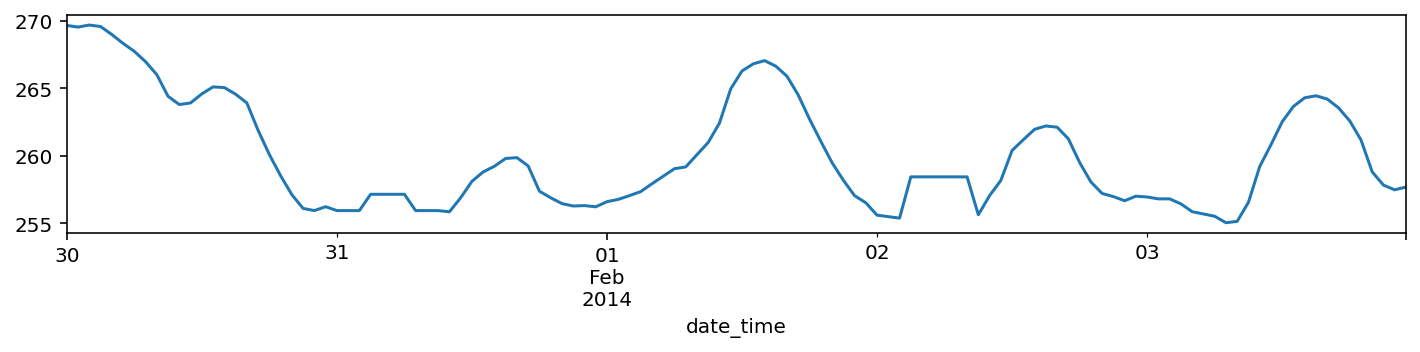

In [30]:
plot_features = df_1['temp']['2014-01-30':'2014-02-03']
_ = plot_features.plot(figsize=(12,2))

#### Rain

Rain seems to have only 1 record with extreme value, I'll just set to the general mean value of rain.

In [31]:
df_1[df_1.rain_1h > 100]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2016-07-11 17:00:00,None,302.11,9831.30,0.00,75,Rain,very heavy rain,5535


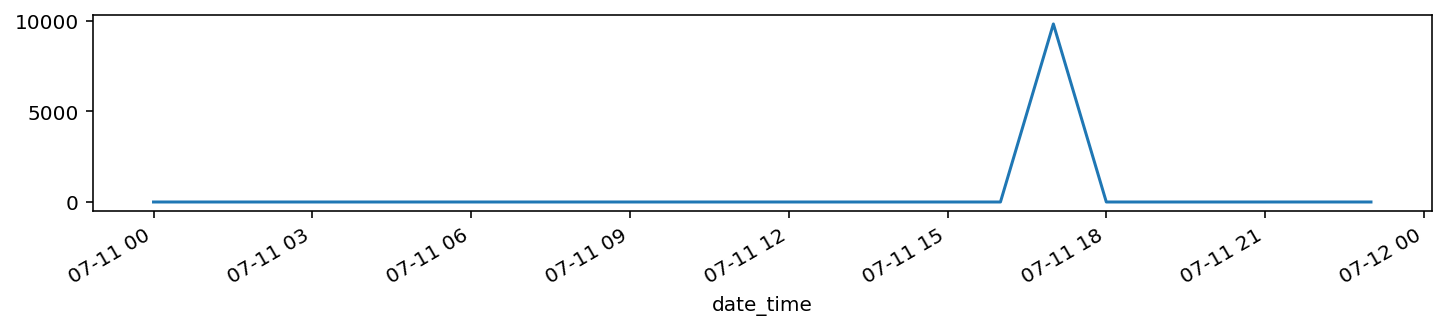

In [32]:
plot_features = df_1['2016-07-11'].rain_1h
_ = plot_features.plot(figsize=(12,2))

In [33]:
df_2 = df_1.copy()
df_2.loc['2016-07-11 17:00:00','rain_1h'] = np.nan
df_2.loc['2016-07-11 17:00:00','rain_1h'] = df_2.rain_1h.mean()

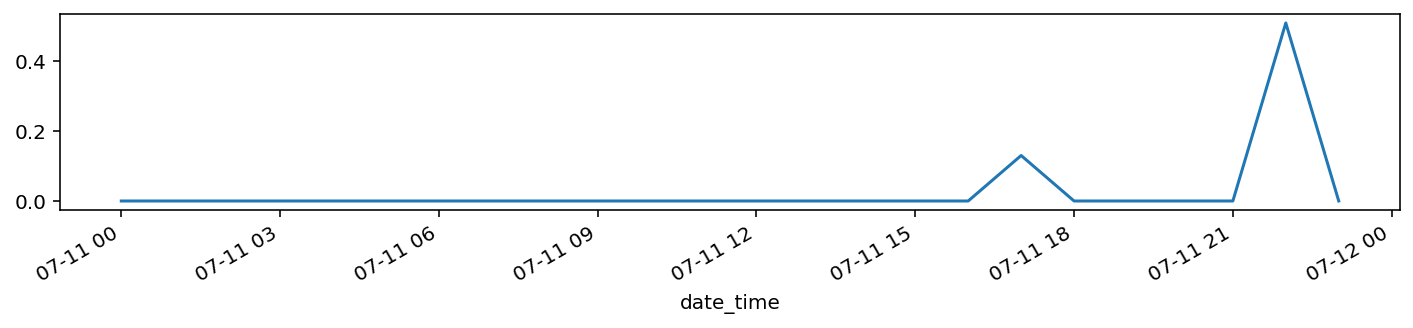

In [34]:
plot_features = df_2['2016-07-11'].rain_1h
_ = plot_features.plot(figsize=(12,2))

#### Snow

I cannot determine if the snow has outliers or not, it seems to be an exceptional winter. I'll keep as is.

In [35]:
df_2[(df_2.snow_1h > .2)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2015-12-23 12:00:00,None,274.33,0.98,0.51,90,Rain,moderate rain,5167
2015-12-23 12:00:00,None,274.33,0.98,0.51,90,Snow,snow,5167
2015-12-23 12:00:00,None,274.33,0.98,0.51,90,Mist,mist,5167
2015-12-23 12:00:00,None,274.33,0.98,0.51,90,Fog,fog,5167
2015-12-23 14:00:00,None,273.74,0.00,0.32,90,Snow,light snow,5182
2015-12-23 14:00:00,None,273.74,0.00,0.32,90,Mist,mist,5182
2015-12-23 14:00:00,None,273.74,0.00,0.32,90,Rain,moderate rain,5182
2015-12-23 16:00:00,None,273.86,0.00,0.32,90,Snow,light snow,5222
2015-12-23 16:00:00,None,273.86,0.00,0.32,90,Mist,mist,5222


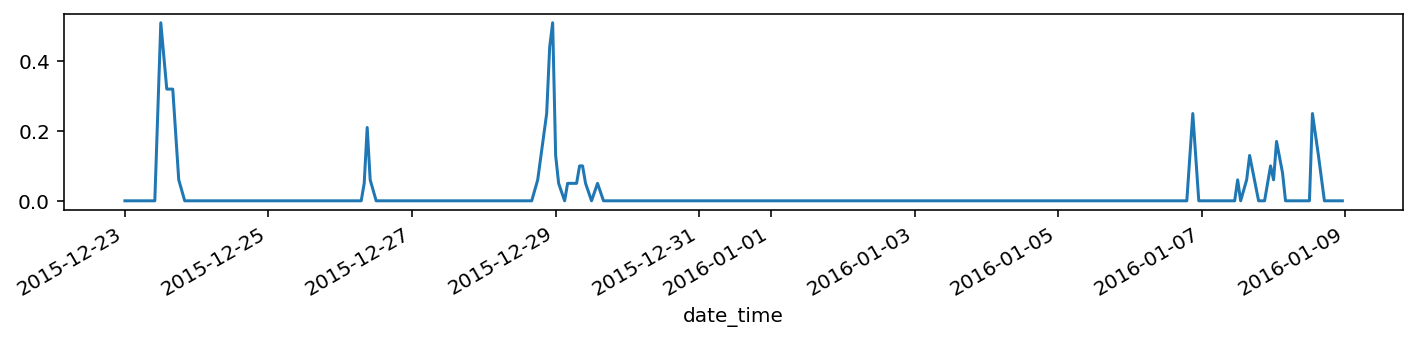

In [36]:
plot_features = df_2['2015-12-23':'2016-01-08'].snow_1h
_ = plot_features.plot(figsize=(12,2))

### Cleaned Data Overview

The data overview looks better now, but still I'm concerned with the missing data block between years 2014 and 2015.

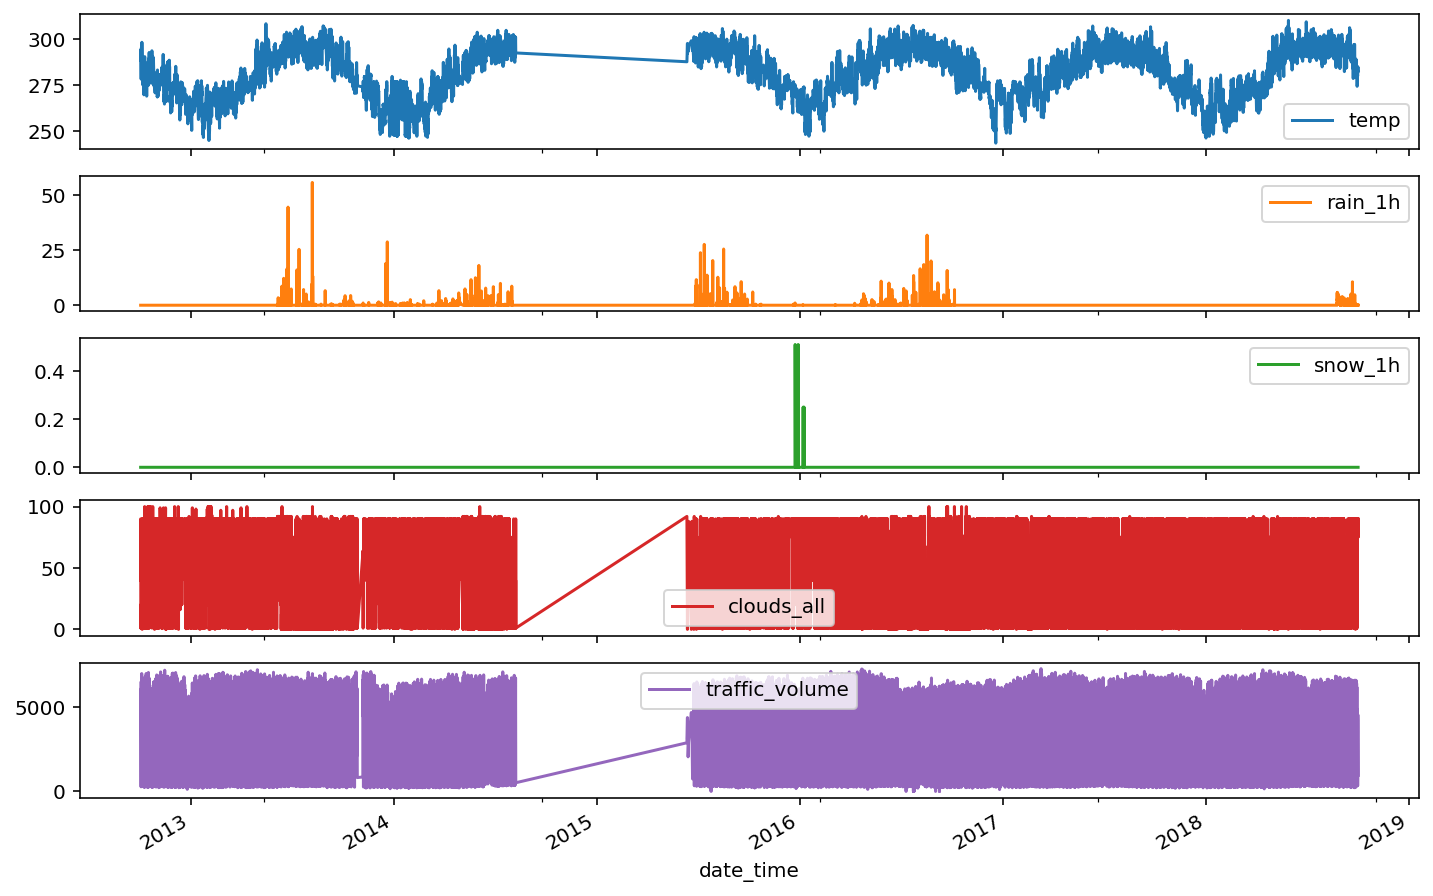

In [37]:
plot_features = df_2[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

### Feature engineering


#### Weather_main and Weather description

I decided to transform the **weather_main** into one-hot encoded variables, and to drop the **weather_description** as I see that it adds kind of redundant information with weather_main.

In [38]:
df_3 = df_2.copy()
df_3.drop(columns=['weather_description'], inplace=True)
df_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 4.2+ MB


In [39]:
df_3 = pd.get_dummies(df_3, columns=['weather_main'], prefix='weather')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   holiday               48204 non-null  object 
 1   temp                  48204 non-null  float64
 2   rain_1h               48204 non-null  float64
 3   snow_1h               48204 non-null  float64
 4   clouds_all            48204 non-null  int64  
 5   traffic_volume        48204 non-null  int64  
 6   weather_Clear         48204 non-null  uint8  
 7   weather_Clouds        48204 non-null  uint8  
 8   weather_Drizzle       48204 non-null  uint8  
 9   weather_Fog           48204 non-null  uint8  
 10  weather_Haze          48204 non-null  uint8  
 11  weather_Mist          48204 non-null  uint8  
 12  weather_Rain          48204 non-null  uint8  
 13  weather_Smoke         48204 non-null  uint8  
 14  weather_Snow          48204 non-nul

#### Holidays and Weekends

I think the valuable information to capture is wether the day is a holiday or a weekend. We don't need to keep track which holiday. So, we will create a new feature `is_holiday` and drop the old feature `holiday`. We don't need to keep track which weekend it is. So, we will create a new feature `is_weekend`.

In [40]:
df_4 = df_3.copy()
df_4['is_holiday'] = df_4.pop('holiday').apply(lambda x: 1 if x != 'None' else 0)
df_4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  48204 non-null  float64
 1   rain_1h               48204 non-null  float64
 2   snow_1h               48204 non-null  float64
 3   clouds_all            48204 non-null  int64  
 4   traffic_volume        48204 non-null  int64  
 5   weather_Clear         48204 non-null  uint8  
 6   weather_Clouds        48204 non-null  uint8  
 7   weather_Drizzle       48204 non-null  uint8  
 8   weather_Fog           48204 non-null  uint8  
 9   weather_Haze          48204 non-null  uint8  
 10  weather_Mist          48204 non-null  uint8  
 11  weather_Rain          48204 non-null  uint8  
 12  weather_Smoke         48204 non-null  uint8  
 13  weather_Snow          48204 non-null  uint8  
 14  weather_Squall        48204 non-nul

In [41]:
# Check sample values that are expected NOT TO BE a holiday
df_4[df_4.is_holiday == 0].head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,is_holiday
date_time,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.00,0.00,40,5545,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 10:00:00,289.36,0.00,0.00,75,4516,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 11:00:00,289.58,0.00,0.00,90,4767,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 12:00:00,290.13,0.00,0.00,90,5026,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 13:00:00,291.14,0.00,0.00,75,4918,0,1,0,0,0,0,0,0,0,0,0,0


In [42]:
# Check sample values that are expected TO BE a holiday
df_4[df_4.is_holiday == 1].head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,is_holiday
date_time,,,,,,,,,,,,,,,,,
2012-10-08,273.08,0.00,0.00,20,455,0,1,0,0,0,0,0,0,0,0,0,1
2012-11-12,288.12,0.00,0.00,87,1000,1,0,0,0,0,0,0,0,0,0,0,1
2012-11-22,278.54,0.00,0.00,20,919,0,0,0,0,0,1,0,0,0,0,0,1
2012-12-25,264.40,0.00,0.00,90,803,0,1,0,0,0,0,0,0,0,0,0,1
2013-01-01,263.49,0.00,0.00,58,1439,0,1,0,0,0,0,0,0,0,0,0,1


In [43]:
df_4.index.day_name().map(lambda x: 1 if x in ['Saturday','Sunday'] else 0)

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='date_time', length=48204)

In [44]:
df_4['is_weekend'] = df_4.index.day_name().map(lambda x: 1 if x in ['Saturday','Sunday'] else 0)
df_4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  48204 non-null  float64
 1   rain_1h               48204 non-null  float64
 2   snow_1h               48204 non-null  float64
 3   clouds_all            48204 non-null  int64  
 4   traffic_volume        48204 non-null  int64  
 5   weather_Clear         48204 non-null  uint8  
 6   weather_Clouds        48204 non-null  uint8  
 7   weather_Drizzle       48204 non-null  uint8  
 8   weather_Fog           48204 non-null  uint8  
 9   weather_Haze          48204 non-null  uint8  
 10  weather_Mist          48204 non-null  uint8  
 11  weather_Rain          48204 non-null  uint8  
 12  weather_Smoke         48204 non-null  uint8  
 13  weather_Snow          48204 non-null  uint8  
 14  weather_Squall        48204 non-nul

In [45]:
# Check sample values that are expected NOT TO BE a weekend
df_4[df_4.is_weekend == 0].index.day_name()

Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       ...
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday'],
      dtype='object', name='date_time', length=34501)

In [46]:
# Check sample values that are expected TO BE a weekend
df_4[df_4.is_weekend == 1].index.day_name()

Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday',
       ...
       'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday',
       'Sunday', 'Sunday', 'Sunday'],
      dtype='object', name='date_time', length=13703)

#### Time

Similarly the `Date Time` column is very useful, but not in this form. We converting it to seconds:

In [47]:
timestamp_s = df_4.index.map(datetime.datetime.timestamp)

My assumption is that the traffic flow is seasonal and periodic based on daily and yearly periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [48]:
day = 24*60*60
year = (365.2425)*day

df_4['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_4['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_4['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_4['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df_4

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,is_holiday,is_weekend,Day sin,Day cos,Year sin,Year cos
date_time,,,,,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.00,0.00,40,5545,0,1,0,0,0,0,0,0,0,0,0,0,0,0.71,-0.71,-1.00,0.02
2012-10-02 10:00:00,289.36,0.00,0.00,75,4516,0,1,0,0,0,0,0,0,0,0,0,0,0,0.50,-0.87,-1.00,0.02
2012-10-02 11:00:00,289.58,0.00,0.00,90,4767,0,1,0,0,0,0,0,0,0,0,0,0,0,0.26,-0.97,-1.00,0.02
2012-10-02 12:00:00,290.13,0.00,0.00,90,5026,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,-1.00,-1.00,0.02
2012-10-02 13:00:00,291.14,0.00,0.00,75,4918,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.26,-0.97,-1.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,283.45,0.00,0.00,75,3543,0,1,0,0,0,0,0,0,0,0,0,0,1,-0.97,0.26,-1.00,-0.01
2018-09-30 20:00:00,282.76,0.00,0.00,90,2781,0,1,0,0,0,0,0,0,0,0,0,0,1,-0.87,0.50,-1.00,-0.01
2018-09-30 21:00:00,282.73,0.00,0.00,90,2159,0,0,0,0,0,0,0,0,0,0,1,0,1,-0.71,0.71,-1.00,-0.01


Text(0.5, 1.0, 'Time of day signal')

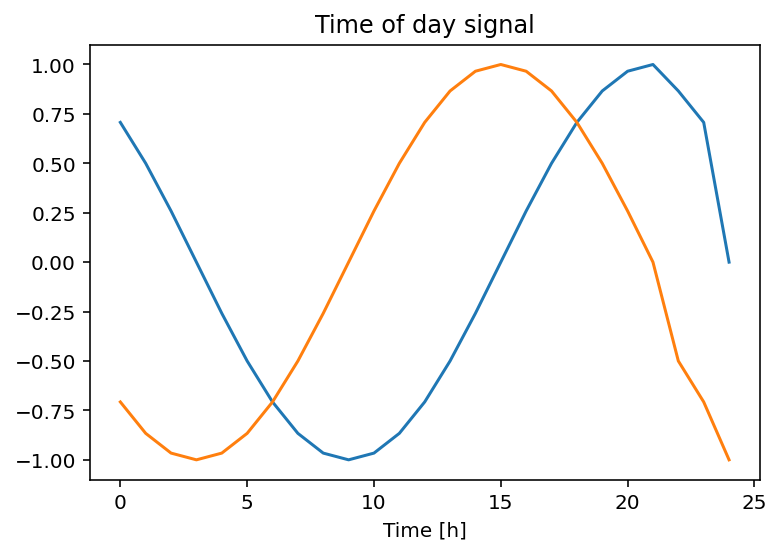

In [49]:
plt.plot(np.array(df_4['Day sin'])[:25])
plt.plot(np.array(df_4['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the **traffic_volume** over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

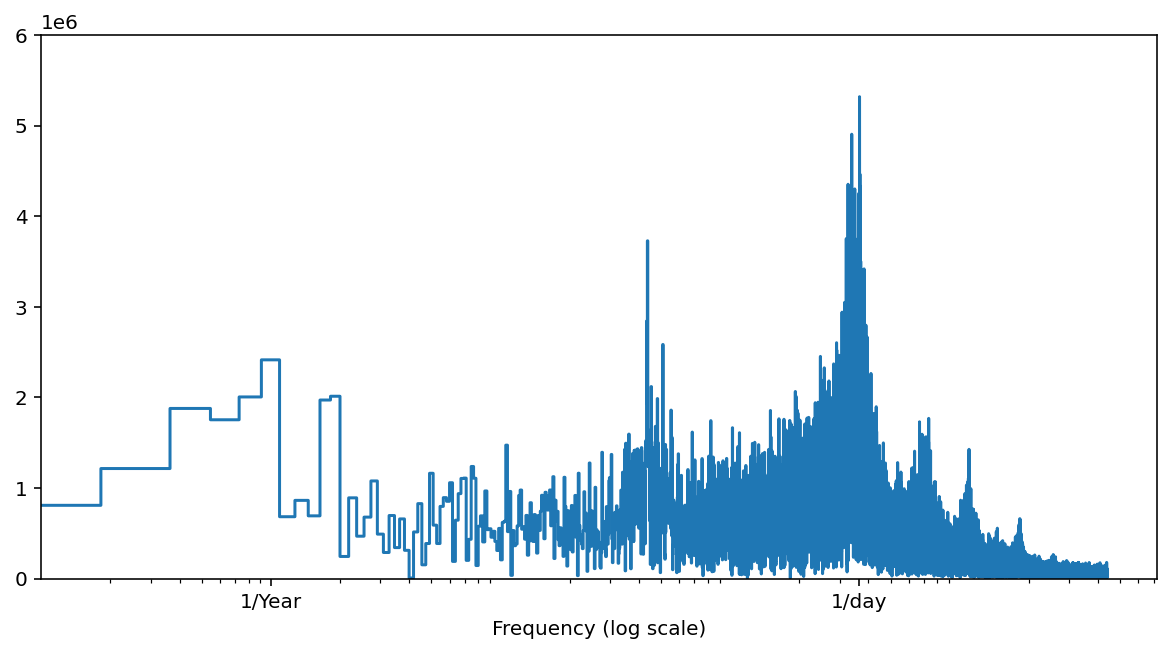

In [50]:
fft = tf.signal.rfft(df_4['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_4['traffic_volume'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.figure(figsize=(10, 5))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 6e6)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Let's also break down the date_time components into other fields.

In [51]:
df_4['dayofweek'] = df_4.index.dayofweek
df_4['day'] = df_4.index.day
df_4['month'] = df_4.index.month
df_4['year'] = df_4.index.year
df_4['day_hour'] = df_4.index.hour

### Reorder dataframe columns

In [52]:
df_5 = df_4.copy()

Set the `traffic_volume` to be the first column for ease of use later when we perform predictions

In [53]:
df_5.insert(0, 'traffic_volume', df_5.pop('traffic_volume'))
df_5.insert(1, 'Day sin', df_5.pop('Day sin'))
df_5.insert(2, 'Day cos', df_5.pop('Day cos'))
df_5.insert(3, 'Year sin', df_5.pop('Year sin'))
df_5.insert(4, 'Year cos', df_5.pop('Year cos'))
df_5.insert(5, 'temp', df_5.pop('temp'))
df_5.insert(6, 'clouds_all', df_5.pop('clouds_all'))
df_5.insert(7, 'rain_1h', df_5.pop('rain_1h'))
df_5.insert(8, 'snow_1h', df_5.pop('snow_1h'))
df_5.insert(9, 'is_weekend', df_5.pop('is_weekend'))
df_5.insert(10, 'is_holiday', df_5.pop('is_holiday'))

### Pairplot


In [54]:
#sns.pairplot(df_5.iloc[:,:11]);

### Save clean data

In [55]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traffic_volume        48204 non-null  int64  
 1   Day sin               48204 non-null  float64
 2   Day cos               48204 non-null  float64
 3   Year sin              48204 non-null  float64
 4   Year cos              48204 non-null  float64
 5   temp                  48204 non-null  float64
 6   clouds_all            48204 non-null  int64  
 7   rain_1h               48204 non-null  float64
 8   snow_1h               48204 non-null  float64
 9   is_weekend            48204 non-null  int64  
 10  is_holiday            48204 non-null  int64  
 11  weather_Clear         48204 non-null  uint8  
 12  weather_Clouds        48204 non-null  uint8  
 13  weather_Drizzle       48204 non-null  uint8  
 14  weather_Fog           48204 non-nul

In [56]:
df_5.to_csv('data/metro_interstate_clean.zip',
          compression=dict(method='zip', archive_name='data/metro_interstate_clean.csv'),
          index=True)

## Prepare for timeseries data processing

### Load clean data


In [57]:
df_clean = pd.read_csv('data/metro_interstate_clean.zip', parse_dates=['date_time'], index_col='date_time')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traffic_volume        48204 non-null  int64  
 1   Day sin               48204 non-null  float64
 2   Day cos               48204 non-null  float64
 3   Year sin              48204 non-null  float64
 4   Year cos              48204 non-null  float64
 5   temp                  48204 non-null  float64
 6   clouds_all            48204 non-null  int64  
 7   rain_1h               48204 non-null  float64
 8   snow_1h               48204 non-null  float64
 9   is_weekend            48204 non-null  int64  
 10  is_holiday            48204 non-null  int64  
 11  weather_Clear         48204 non-null  int64  
 12  weather_Clouds        48204 non-null  int64  
 13  weather_Drizzle       48204 non-null  int64  
 14  weather_Fog           48204 non-nul

In [58]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
traffic_volume,48204.00,3259.82,1986.86,0.00,1193.00,3380.00,4933.00,7280.00
Day sin,48204.00,0.01,0.71,-1.00,-0.71,0.00,0.71,1.00
Day cos,48204.00,0.01,0.71,-1.00,-0.71,0.00,0.71,1.00
Year sin,48204.00,0.01,0.70,-1.00,-0.67,-0.01,0.71,1.00
Year cos,48204.00,-0.03,0.72,-1.00,-0.74,-0.09,0.71,1.00
temp,48204.00,281.26,12.71,243.39,272.16,282.45,291.81,310.07
clouds_all,48204.00,49.36,39.02,0.00,1.00,64.00,90.00,100.00
rain_1h,48204.00,0.13,1.00,0.00,0.00,0.00,0.00,55.63
snow_1h,48204.00,0.00,0.01,0.00,0.00,0.00,0.00,0.51
is_weekend,48204.00,0.28,0.45,0.00,0.00,0.00,1.00,1.00


Let's check for duplicate hourly entries, these are records having the same date_hour, which is not right as per the expectation of hourly samples.


In [59]:
df_clean.index.duplicated().sum()

7629

* There 7629 duplicate hourly entries.
* We should fix this by resampling the data to be on 1 hour basis, so that each record resembles only one hour.
* Duplicate hour records will be averaged within the same hour.
* This can be a problem for the kaggle submission.
* We need to manipulate this without messing the kaggle expected submission IDs.

**Note:**  
The last 5000 records for the kaggle competition submission actually are not 5000 hours, because if we do thorough data preprocessing, we’ll probably collapse the “repeated” records into a single day_hour, this will certainly shift the expected values for the kaggle submission.
Initially, I was aware of that and treated the dataset as hour per record not as actual timeseries set with time unit indexed dataset.

### Split the data

We'll keep the last 5,000 records for the test set and the competition submission. Then, we'll assign 10,000 records for validation.

The data will **not** be randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [60]:
column_indices = {name: i for i, name in enumerate(df_clean.columns)}
print('Full dataset:\t', df_clean.shape[0])
num_features = df_clean.shape[1]
print('Number of features:', num_features)

Full dataset:	 48204
Number of features: 27


In [61]:
sorted(column_indices.items(), key=lambda x: x[1])

[('traffic_volume', 0),
 ('Day sin', 1),
 ('Day cos', 2),
 ('Year sin', 3),
 ('Year cos', 4),
 ('temp', 5),
 ('clouds_all', 6),
 ('rain_1h', 7),
 ('snow_1h', 8),
 ('is_weekend', 9),
 ('is_holiday', 10),
 ('weather_Clear', 11),
 ('weather_Clouds', 12),
 ('weather_Drizzle', 13),
 ('weather_Fog', 14),
 ('weather_Haze', 15),
 ('weather_Mist', 16),
 ('weather_Rain', 17),
 ('weather_Smoke', 18),
 ('weather_Snow', 19),
 ('weather_Squall', 20),
 ('weather_Thunderstorm', 21),
 ('dayofweek', 22),
 ('day', 23),
 ('month', 24),
 ('year', 25),
 ('day_hour', 26)]

The split distribution without timeseries resampling to 1 hour samples (Has duplicates)

In [62]:
train_df0 = df_clean[:-15000]
#train_df = df_clean[:'2014-08-07']
print('train_df:\t', train_df0.shape[0])
val_df0 = df_clean[-15000:-5000]
#val_df = df_clean['2015-06-12':][:-5000]
print('val_df:\t\t', val_df0.shape[0])
test_df0 = df_clean[-5000:]
print('test_df:\t', test_df0.shape[0])

train_df:	 33204
val_df:		 10000
test_df:	 5000


The split distribution after timeseries resampling to 1 hour samples (No duplicates).

I'm keeping the kaggle_df as the reference dataframe that will have the original data_time records IDs for later matching before final submission.

In [63]:
train_df = df_clean[:-15000].resample('1H').mean().pad()
print('train_df:\t', train_df.shape[0])
val_df = df_clean[-15000:-5000].resample('1H').mean().pad()
print('val_df:\t\t', val_df.shape[0])
test_df = df_clean[-5000:].resample('1H').mean().pad()
print('test_df:\t', test_df.shape[0])
kaggle_df = df_clean[-5000:]
print('kaggle_df:\t', kaggle_df.shape[0])

train_df:	 40110
val_df:		 8359
test_df:	 4083
kaggle_df:	 5000


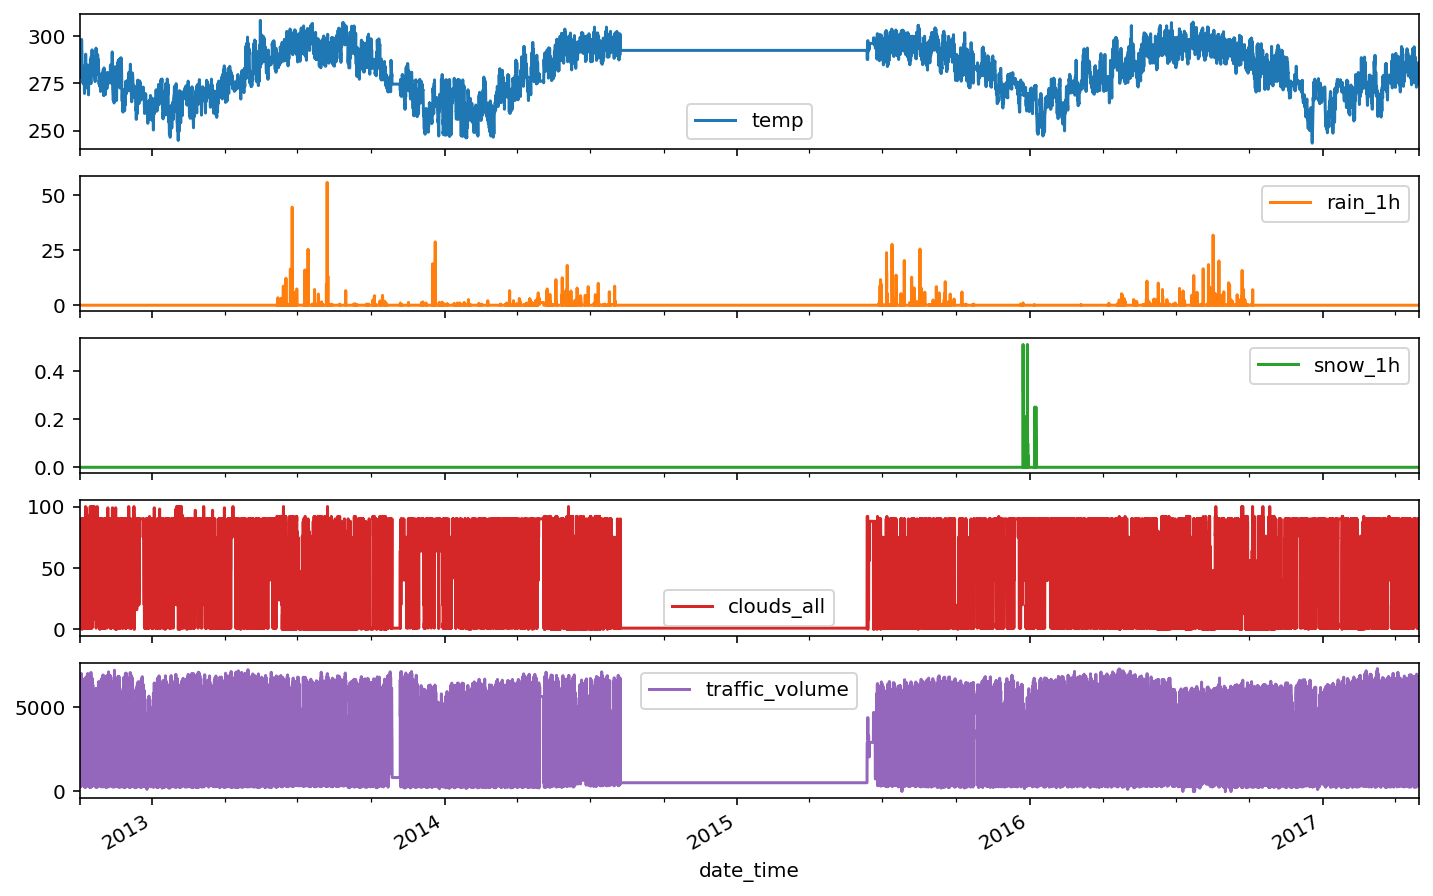

In [64]:
plot_features = train_df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

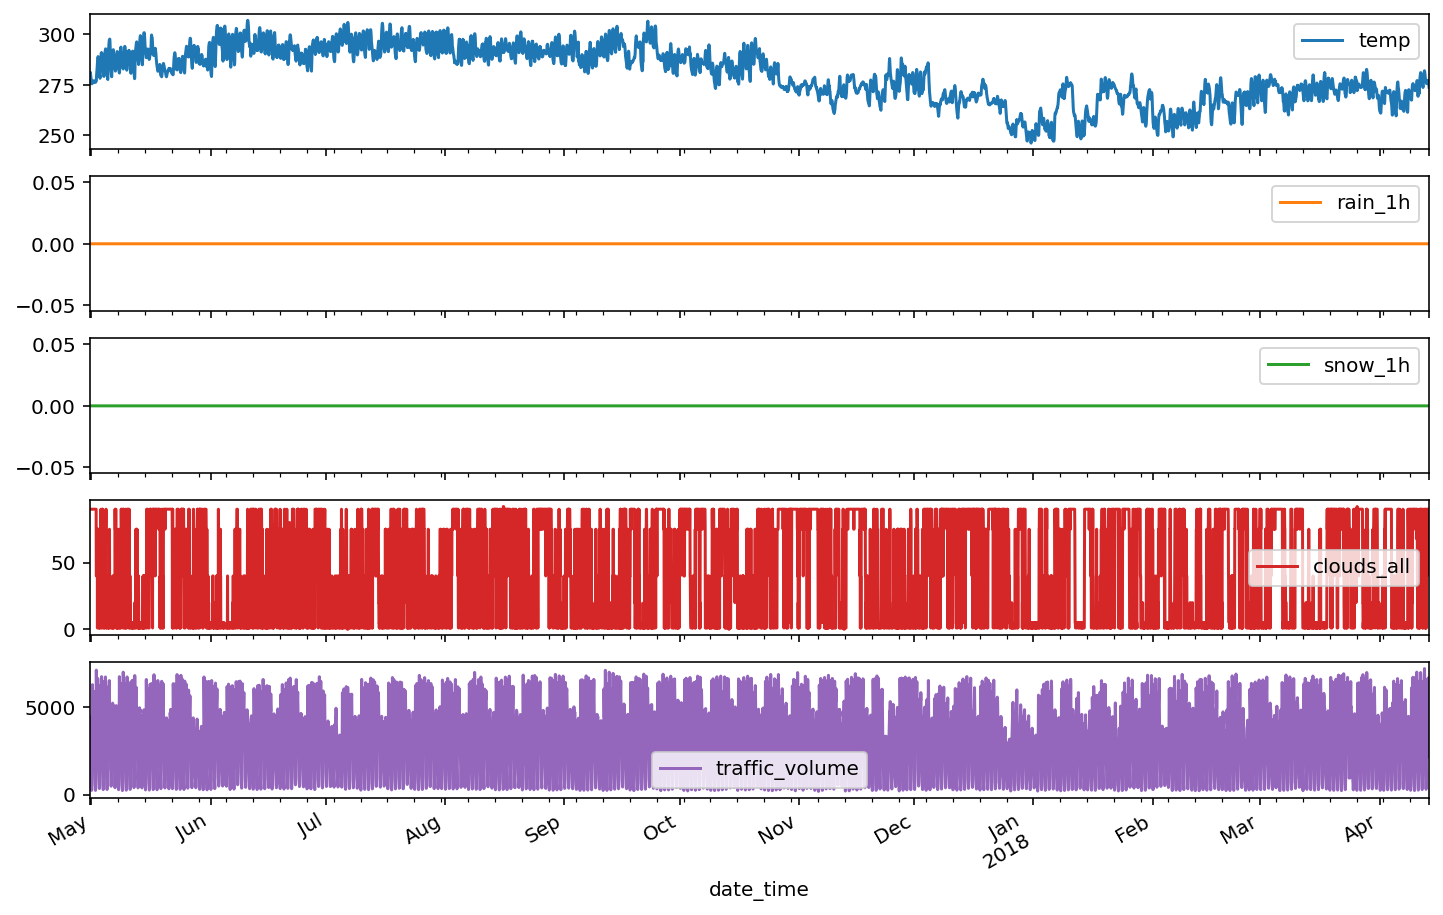

In [65]:
plot_features = val_df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

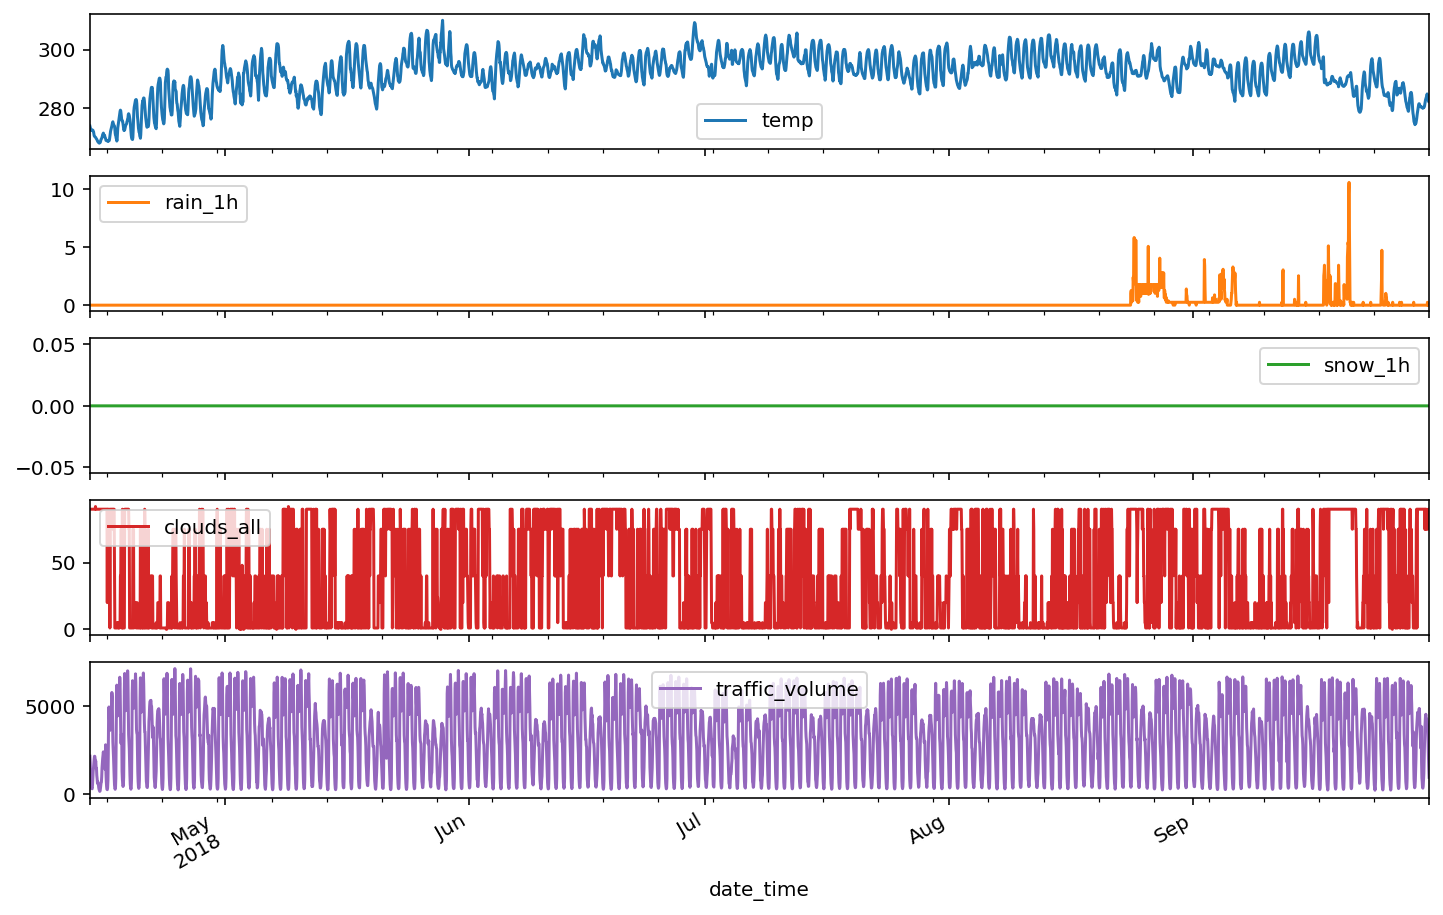

In [66]:
plot_features = test_df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

I notice that that the validation data has no rain or snow data point. Not sure how will this affect the Testing predictions.

### Normalize the data

It is important to scale features before training a neural network. I tested the results using both MinMaxScaler and StandardScaler. I got better results with the MinMaxScaler, So I'll be using scikit-learn MinMaxScaler.

In [67]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [68]:
my_scaler = MinMaxScaler().fit(train_df)
my_scaler_tv = MinMaxScaler().fit(train_df[['traffic_volume']])
scaled_train_df = pd.DataFrame(my_scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
scaled_val_df = pd.DataFrame(my_scaler.transform(val_df), index=val_df.index, columns=val_df.columns)
scaled_test_df = pd.DataFrame(my_scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

#train_df.traffic_volume[0], scaled_train_df.traffic_volume[0], scaled_train_df.traffic_volume[0] / my_scaler.scale_[0]
#train_df.traffic_volume[0], scaled_train_df.traffic_volume[0], scaled_train_df.traffic_volume[0] * my_scaler.scale_[0] + my_scaler.mean_[0]

Let's test the normalizaing and denormalizing scheme

In [69]:
train_df.traffic_volume[0], scaled_train_df.traffic_volume[0], np.float(my_scaler_tv.inverse_transform(scaled_train_df[['traffic_volume']])[0])

(5545.0, 0.7616758241758241, 5545.0)

In [70]:
# Single value denormalization
np.float(my_scaler_tv.inverse_transform(np.array([[.7]])))

5096.0

In [71]:
my_scaler.__class__

sklearn.preprocessing._data.MinMaxScaler

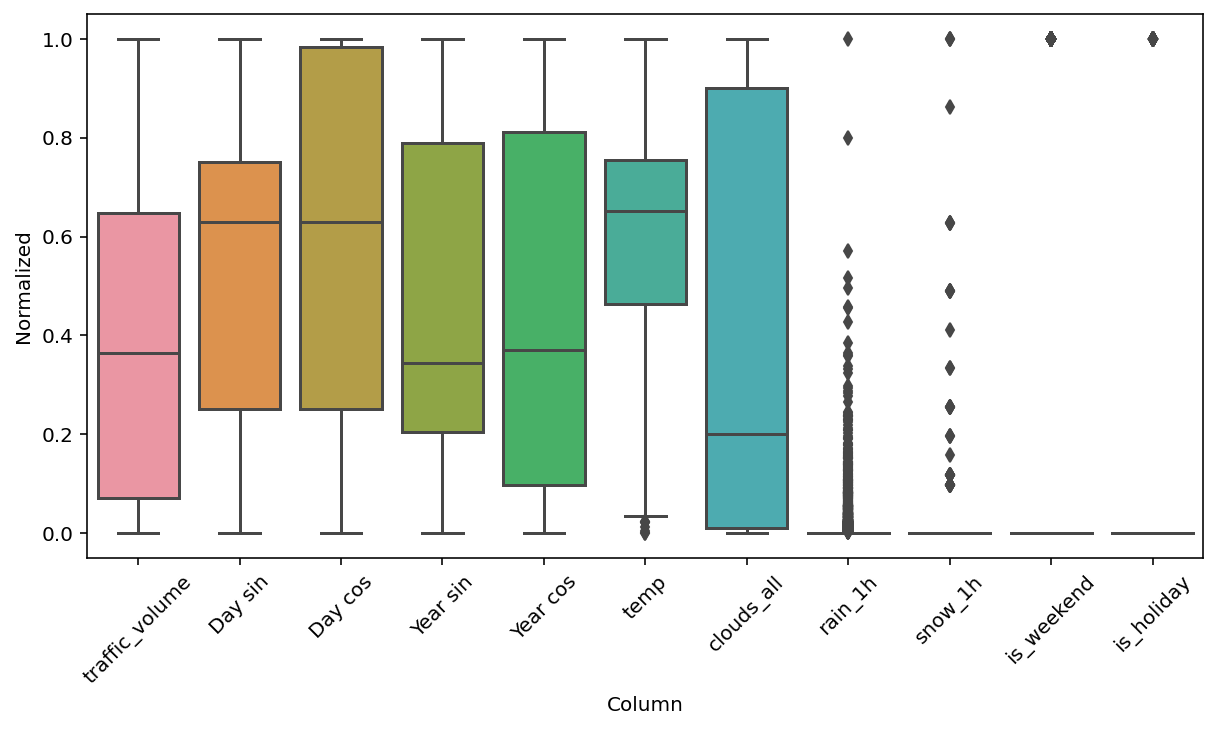

In [72]:
df_scaled = scaled_train_df.iloc[:,:11].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='Column', y='Normalized', data=df_scaled)
_ = ax.set_xticklabels(scaled_train_df.keys(), rotation=45)

The data is showing rain and snow having alot of outliers. I'm unaware if this is corrupt data or if that's the actual weather in that area.

## Utility functions

In [73]:
# Special Characters for Output Formating
StartBold = "\033[1m"
EndBold = "\033[0m"

### WindowGenerator

I modified the WindowGenerator class to have all the required methods and properties consolidated from the beginging in contrast to the original design of adding the methods and properties at subsequent steps.

In [74]:
'''
[Code Provided by the tutorial]
The WindowGenerator class.
Start by creating the `WindowGenerator` class. The `__init__` method includes
all the necessary logic for the input and label indices.
It also takes the train, eval, and test dataframes as input.
These will be converted to `tf.data.Dataset`s of windows later.

This class can:

1 - Handle the indexes and offsets as shown in the diagrams above.
2 - Split windows of features into a (features, labels) pairs.
3 - Plot the content of the resulting windows.
4 - Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.
'''
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, batch_size=32,
               train_df=scaled_train_df, val_df=scaled_val_df, test_df=scaled_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.example = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.batch_size = batch_size

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size} = {self.input_width}+({self.shift-self.label_width}+{self.label_width})',
        f'Batch size: {self.batch_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices} start: [{self.label_start}]',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    '''
      Given a list consecutive inputs, the split_window method will convert
      them to a window of inputs and a window of labels.
    '''
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
    '''
      The plot method that allows a simple visualization of the split window
    '''
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
    # Maskar: Added this line show that we are only showing n slices
    plt.suptitle(f'Showing only {max_n} slices')

  def make_dataset(self, data):
    '''
      Make_dataset method will take a time series DataFrame and convert it to
      a tf.data.Dataset of (input_window, label_window) pairs using the
      preprocessing.timeseries_dataset_from_array function.
    '''
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False, # Maskar: I changed this to False
        batch_size=self.batch_size, # 32,
        )

    ds = ds.map(self.split_window)

    return ds

  # The WindowGenerator object holds training, validation and test data.
  # Add properties for accessing them as tf.data.Datasets using the above make_dataset method.
  # Also add a standard example batch for easy access and plotting:
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  @example.setter
  def example(self, var):
    self._example = var

### Plotting

In [75]:
def plot_train_validation(history, validation_data, metric='mean_absolute_error'):
  '''
    Function to plot the training and validation accuracy progress with epochs for a single model
  '''
  plt.plot(history.history[metric], label='train')  # For TF2
  plt.plot(history.history['val_'+metric], label='valid.')  # For TF2
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  #plt.xticks(range(1,len(history.history['loss'])+1,2))
  #plt.ylim([0.5, 1])
  plt.title(f'{len(history.history[metric])} epochs')
  plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
  plt.legend(loc='upper right')
  plt.show()

  # Evaluate the learned model with validation set
  print(f'\n\n{StartBold}Validation Scores:{EndBold}\n')
  _ = history.model.evaluate(validation_data, verbose=2)


In [76]:
class TrainingPlot(Callback):
    '''
      A keras callback helper function to plot
      the taining/validation plot after each epoch
    '''
    def __init__(self, loss_metric='mean_absolute_error'):
      super().__init__()
      self.loss_metric = loss_metric

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get(self.loss_metric)
        val_loss = logs.get('val_'+self.loss_metric)
                
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(loss)
        self.val_losses.append(val_loss)
        
        # Plots every n-th epoch
        if epoch > 0 and epoch%1==0:
            
            # Clear the previous plot
            IPython.display.clear_output(wait=True)
            #clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            #plt.style.use("seaborn")            
            #plt.figure(figsize=(10,3))
            plt.xlabel('Epoch')
            plt.ylabel(self.loss_metric)
            plt.plot(N, self.losses, label='train')
            plt.plot(N, self.val_losses, label='valid.')
            plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
            val_denorm = np.float(my_scaler_tv.inverse_transform(np.array([[val_loss]])))
            plt.title(f'Last validation value = {val_denorm:.2f}')
            plt.legend(loc='upper right')          
            plt.show()

### Compile and fit

In [77]:
def compile_and_fit(model, window, patience=5, max_epochs=100,
                    model_label='model', log_dict=None):
  plot_metrics = TrainingPlot()

  rlr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      min_delta=0.001,
      patience=patience,
      mode='min',
      verbose=1
      )

  #mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      #min_delta=0.0001,
      patience=patience,
      mode='min',
      restore_best_weights=True
      )

  model.compile(
      optimizer=tf.optimizers.Adam(),
      loss=tf.losses.MeanSquaredError(),
      metrics=[tf.metrics.MeanAbsoluteError()]
      )

  history = model.fit(
      window.train,
      #batch_size = window.batch_size,  # Maskar: added reference to the batch size
      epochs=max_epochs,
      validation_data=window.val,
      callbacks=[plot_metrics, early_stopping, rlr]
      )
  
  if log_dict:
    log_dict['my_models'][model_label] = model

    IPython.display.clear_output()

    print(f'\n\n{StartBold}Training vs. Validation:{EndBold}\n')
    plot_train_validation(history, window.val)

    log_dict['multi_val_performance'][model_label] = model.evaluate(window.val, verbose=0)
    log_dict['multi_performance'][model_label] = model.evaluate(window.train, verbose=0)


  predictions = model.predict(window.val)
  evaluate_predictions(val_df.traffic_volume, predictions)
  
  return history

### Evaluate predictions

In [78]:
def evaluate_predictions(y_true, y_pred, plot_start_index=-500):
  print(f'\n\n{StartBold}Predictions Evaluation:{EndBold}\n')
  y_p = np.asarray(my_scaler_tv.inverse_transform(y_pred.reshape(-1,1))).ravel()
  n_predictions = len(y_p)
  y = np.asarray(y_true[-n_predictions:]).ravel()
  print('Predictions:', n_predictions)
  mae = np.float(tf.metrics.mean_absolute_error(y, y_p))
  mae_scaled = np.float(my_scaler_tv.transform(np.array([[mae]])))
  print(f'MAE: {mae:.2f} ({mae_scaled:.4f})')

  plt.subplots(figsize=(15,2))
  plt.plot(y[plot_start_index:], marker='.', label='true')
  plt.plot(y_p[plot_start_index:], marker='.', label='predicted')
  plt.legend()
  plt.show()

### Export for submission

In [79]:

def export_submission(y_pred, filename='submission.csv'):
  '''
    Function to export the prediction results for submission
  '''
  denorm_predictions = my_scaler_tv.inverse_transform(y_pred)
  df = pd.DataFrame(
      denorm_predictions,
      columns=['prediction'],
      index=pd.RangeIndex(1,len(y_pred)+1, name='id')
      )
  df.to_csv(filename)

This function handles the mapping between the clean time series predictions that I got from my modeling and the original Kaggle dataset 5000 records ids. Repeating the predicted values for each date_hour to match the requierd id position of the kaggle submission.

In [80]:
def prepare_for_kaggle(predictions, df, kaggle_df, window_size=7):
  a = []
  n = len(kaggle_df) - window_size
  print('Required Predictions:\t', n)
  print('Clean Predictions:\t', predictions.shape[0])
  source_df = df[-predictions.shape[0]:]
  print('\nMissing Days in Kaggle DF due to records collapse:\n')
  for i,y in enumerate(kaggle_df[-n:].index):
    try:
      idx = source_df.index.get_loc(y)
      pred_tv = np.float(predictions[idx])
      a.append(pred_tv)
    except:
      pass
      print('\t',y)
      a.append(0)

  result = np.array(a)
  print('\nPrepared Predictions:\t',result.shape[0])
  return result.reshape(-1,1)

## The models


### The required window

Total window size: 8 = 6+(1+1)
Batch size: 32
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']

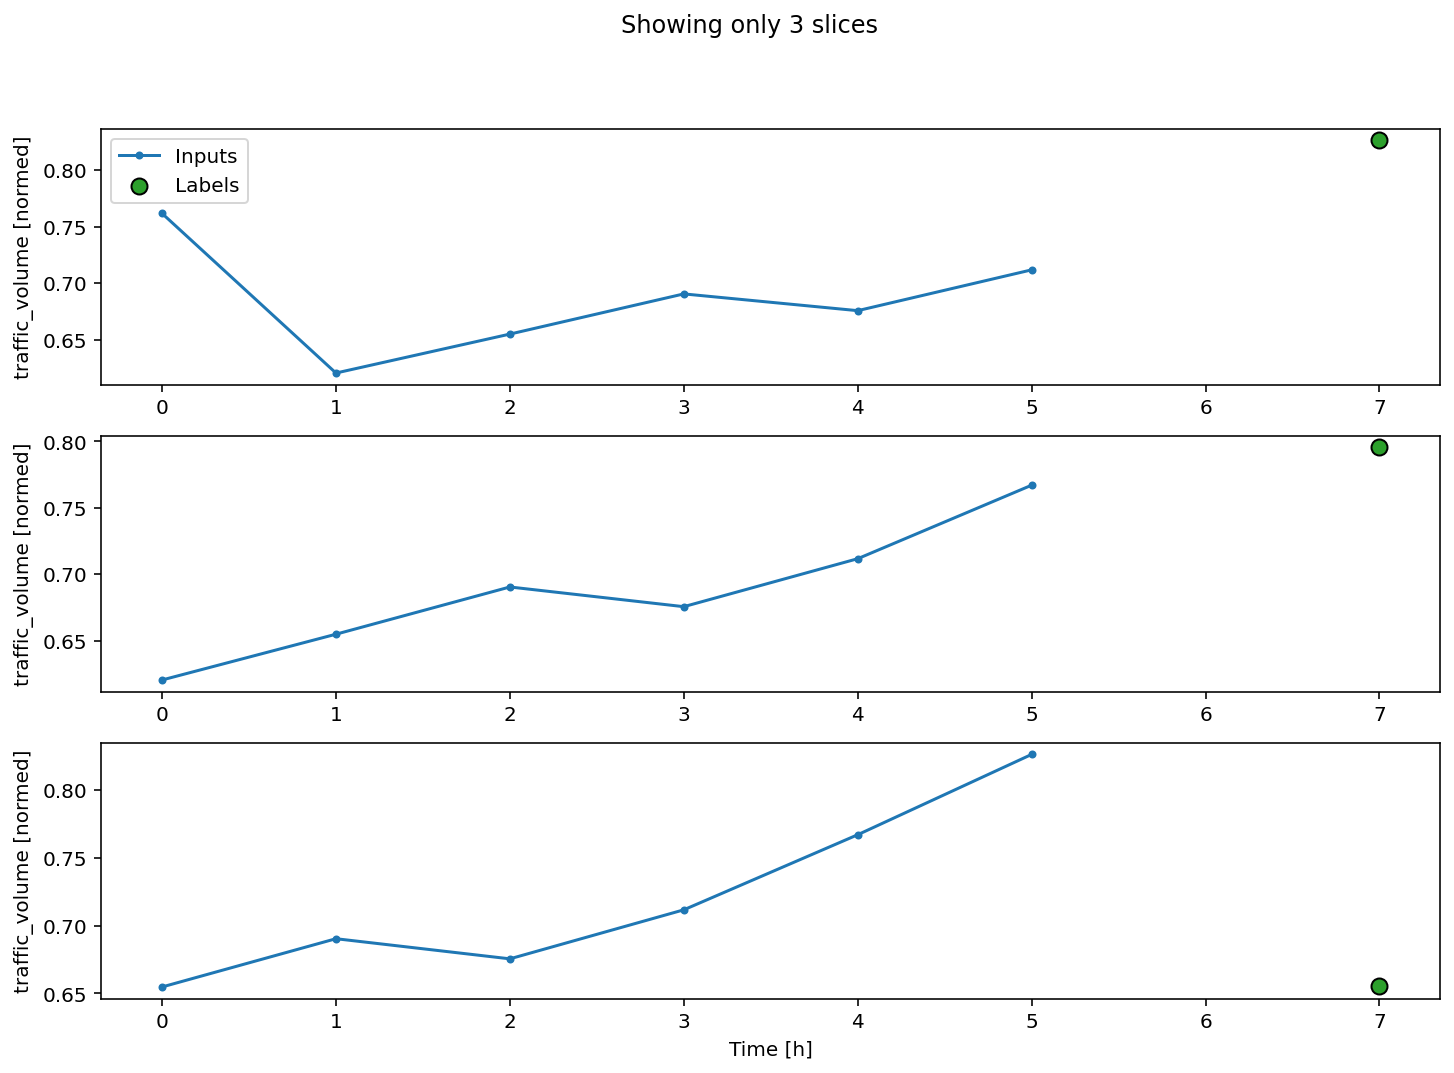

In [81]:
INPUT_WIDTH = 6
OUT_STEPS = 1
SHIFT = 2
base_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=32
                               )

base_window.plot()
base_window

### Baseline Models

In [82]:
multi_val_performance = {}
multi_performance = {}
my_models = {}

my_log = {
    'multi_val_performance':multi_val_performance,
    'multi_performance':multi_performance,
    'my_models':my_models
    }

I set all the models to converge into a single output value, which is the traffic volume at the 8th day based on 6 days input of the full features.

#### Dense

Using only `layers.Dense` between the input and output gives a decent linear model.



Training vs. Validation:



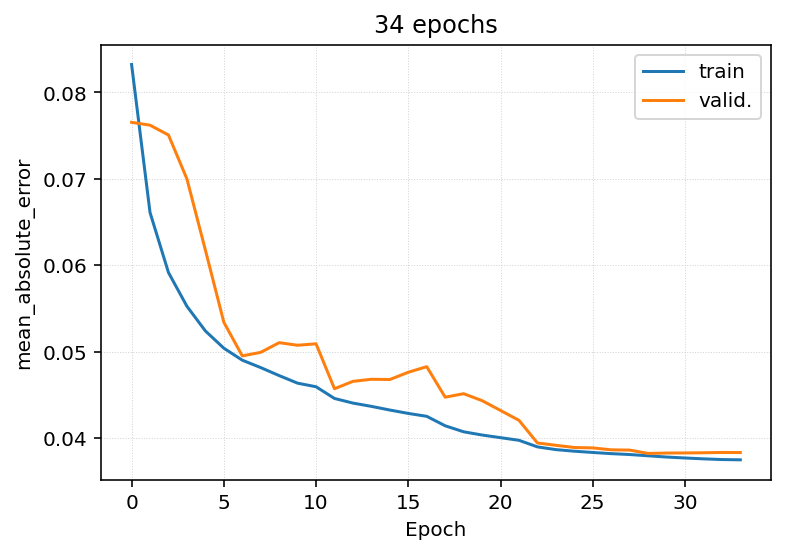



Validation Scores:

261/261 - 1s - loss: 0.0032 - mean_absolute_error: 0.0382


Predictions Evaluation:

Predictions: 8352
MAE: 278.24 (0.0382)


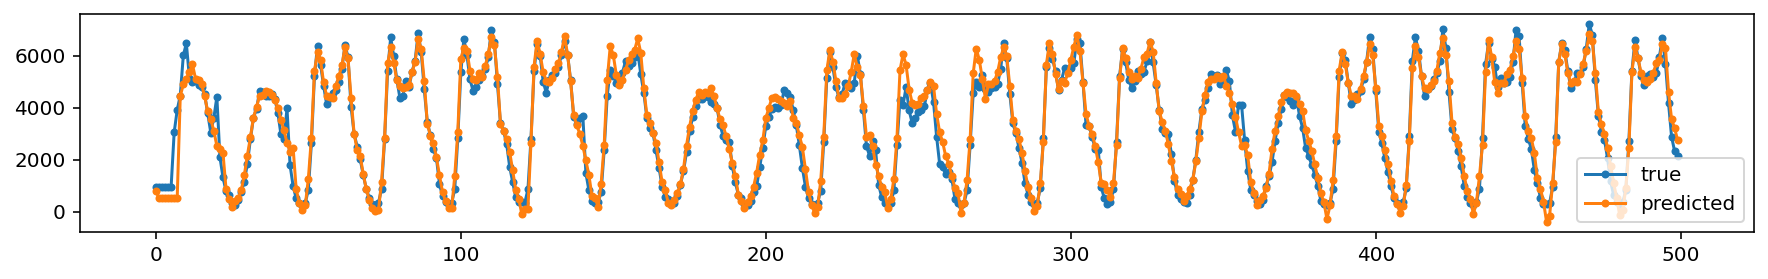

CPU times: user 4min 51s, sys: 42.1 s, total: 5min 33s
Wall time: 4min 34s


In [83]:
%%time
model_label = 'Dense'
current_window = base_window

dense_model = tf.keras.Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(dense_model, current_window,
                          model_label=model_label, log_dict=my_log)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:



Training vs. Validation:



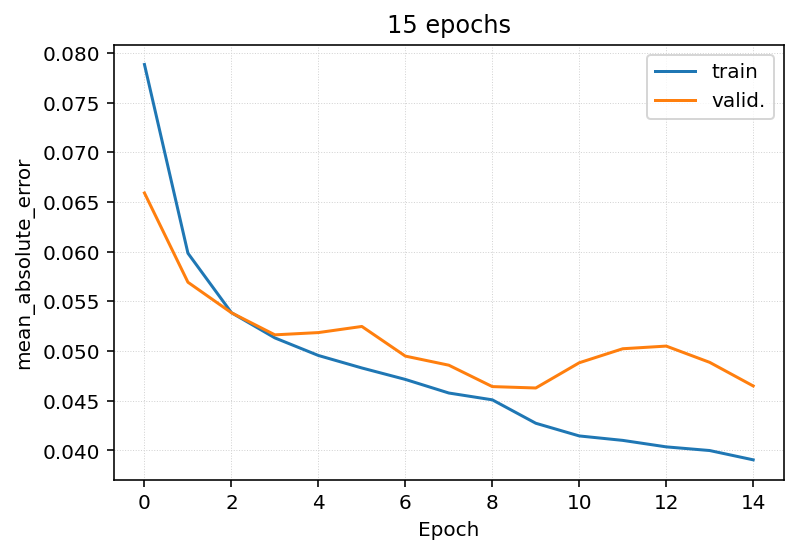



Validation Scores:

261/261 - 1s - loss: 0.0048 - mean_absolute_error: 0.0463


Predictions Evaluation:

Predictions: 8352
MAE: 336.88 (0.0463)


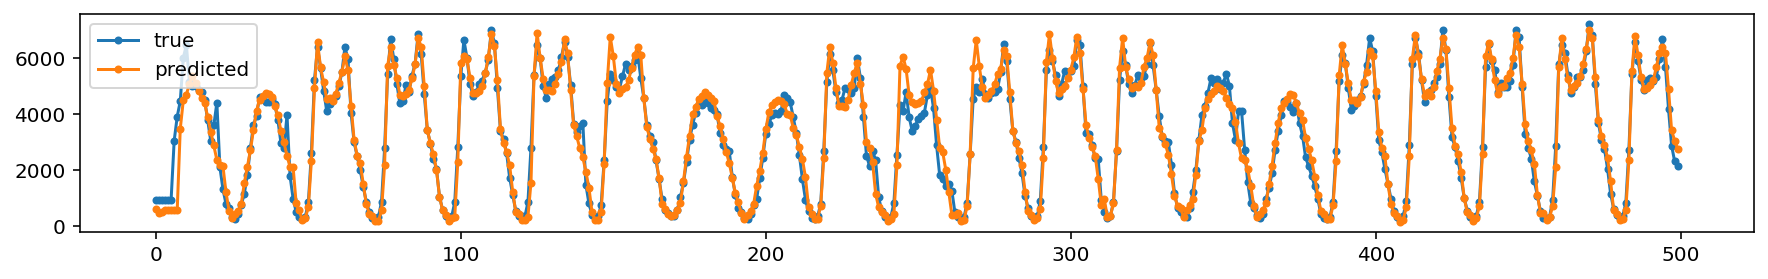

CPU times: user 2min 24s, sys: 20.2 s, total: 2min 44s
Wall time: 2min 32s


In [84]:
%%time
model_label = 'Conv'
current_window = base_window

CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(conv_model, current_window,
                          model_label=model_label, log_dict=my_log)

#### RNN



Training vs. Validation:



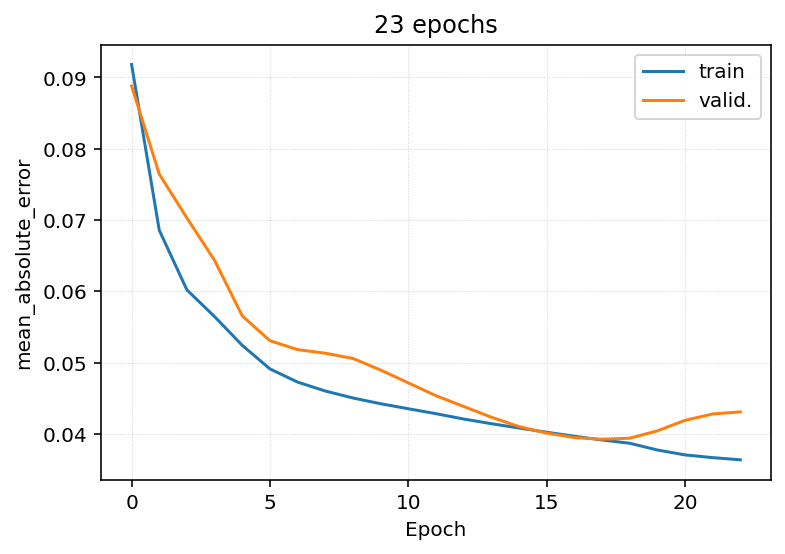



Validation Scores:

261/261 - 1s - loss: 0.0032 - mean_absolute_error: 0.0392


Predictions Evaluation:

Predictions: 8352
MAE: 285.65 (0.0392)


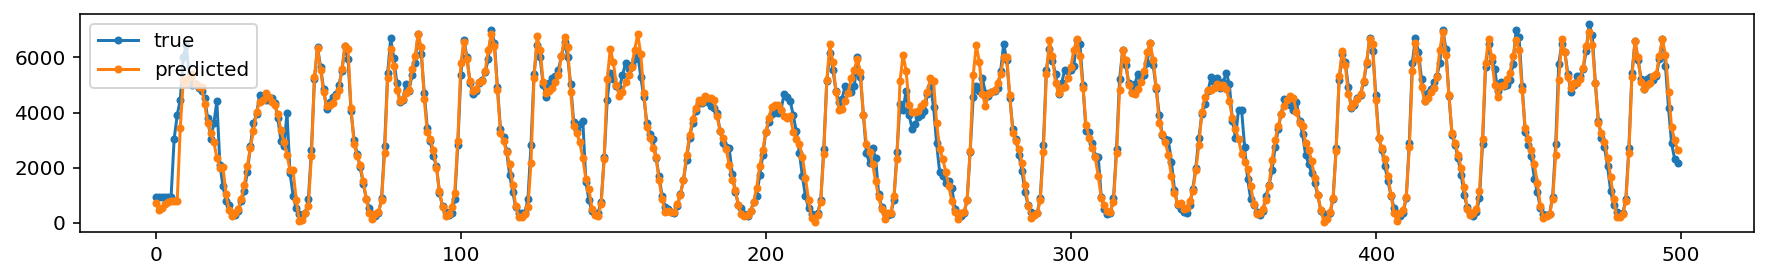

CPU times: user 3min 45s, sys: 29.5 s, total: 4min 14s
Wall time: 3min 20s


In [85]:
%%time
model_label = 'LSTM'
current_window = base_window

lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    Dense(OUT_STEPS)
])

history = compile_and_fit(lstm_model, current_window,
                          model_label=model_label, log_dict=my_log)

### My Models

In [86]:
# I created another WindowGen to experiment with the batch size in my models
my_window1 = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=32
                               )
my_window1

Total window size: 8 = 6+(1+1)
Batch size: 32
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']

In [87]:
# I created another WindowGen to experiment with the batch size in my models
my_window2 = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=64
                               )
my_window2

Total window size: 8 = 6+(1+1)
Batch size: 64
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']

#### Model 1



Training vs. Validation:



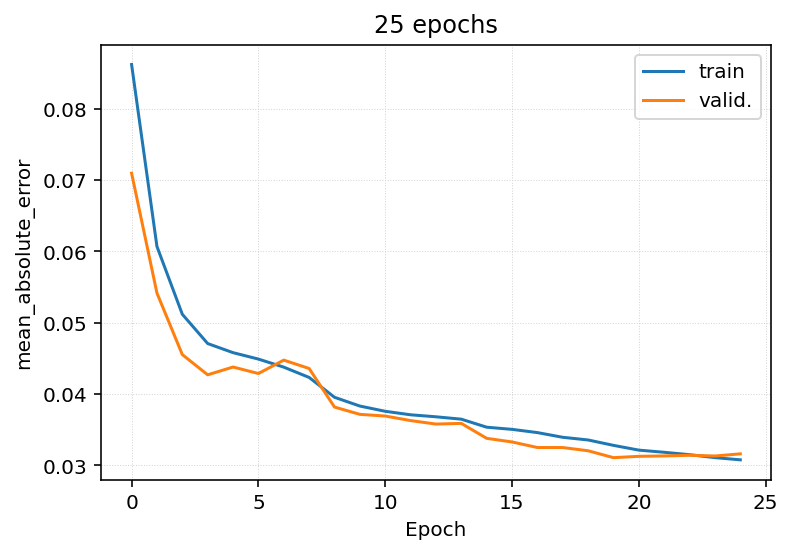



Validation Scores:

261/261 - 1s - loss: 0.0023 - mean_absolute_error: 0.0311


Predictions Evaluation:

Predictions: 8352
MAE: 226.28 (0.0311)


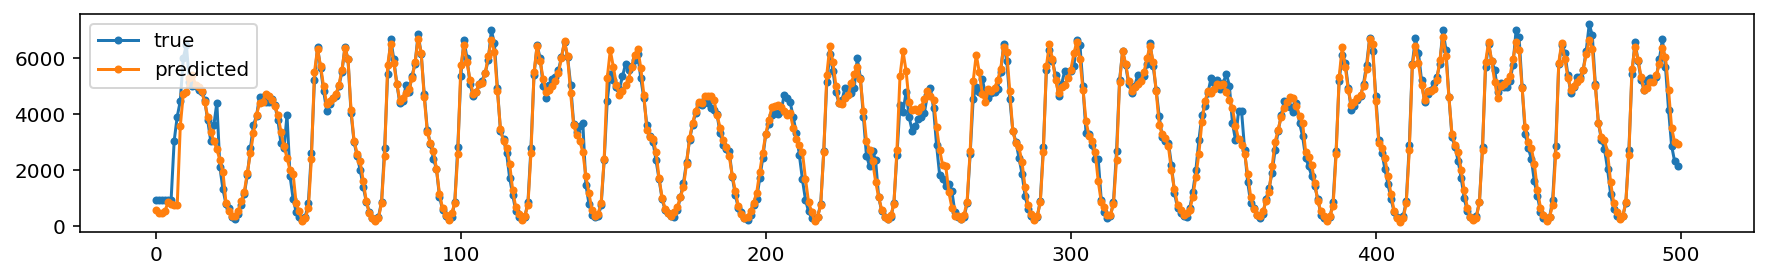

CPU times: user 5min 11s, sys: 32.3 s, total: 5min 43s
Wall time: 4min 16s


In [88]:
%%time
model_label = 'MyLSTM_1'
current_window = my_window1

my_lstm_model = tf.keras.Sequential([
    LSTM(512, return_sequences=True),
    LSTM(512, return_sequences=False),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(my_lstm_model, current_window,
                          model_label=model_label, log_dict=my_log,
                          )

In [89]:
my_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 512)            1105920   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 3,730,945
Trainable params: 3,730,945
Non-trainable params: 0
_________________________________________________________________


#### Model 2 (Kaggle Submission)



Training vs. Validation:



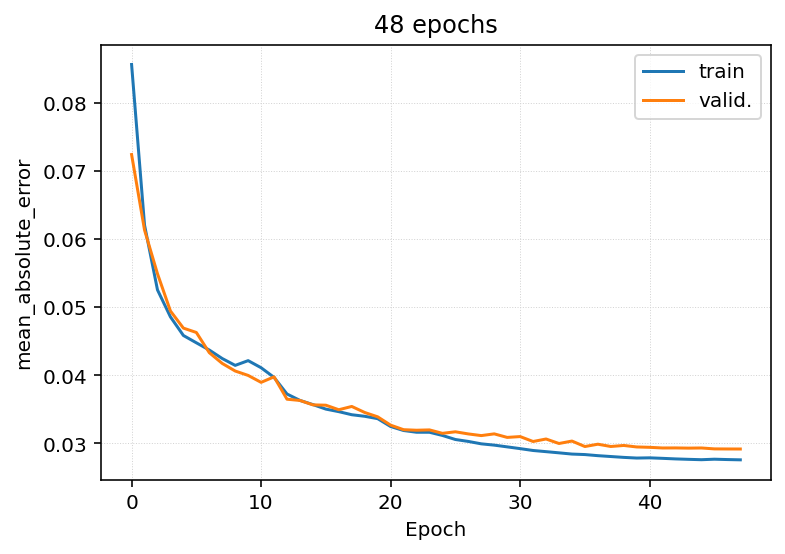



Validation Scores:

261/261 - 1s - loss: 0.0020 - mean_absolute_error: 0.0293


Predictions Evaluation:

Predictions: 8352
MAE: 213.65 (0.0293)


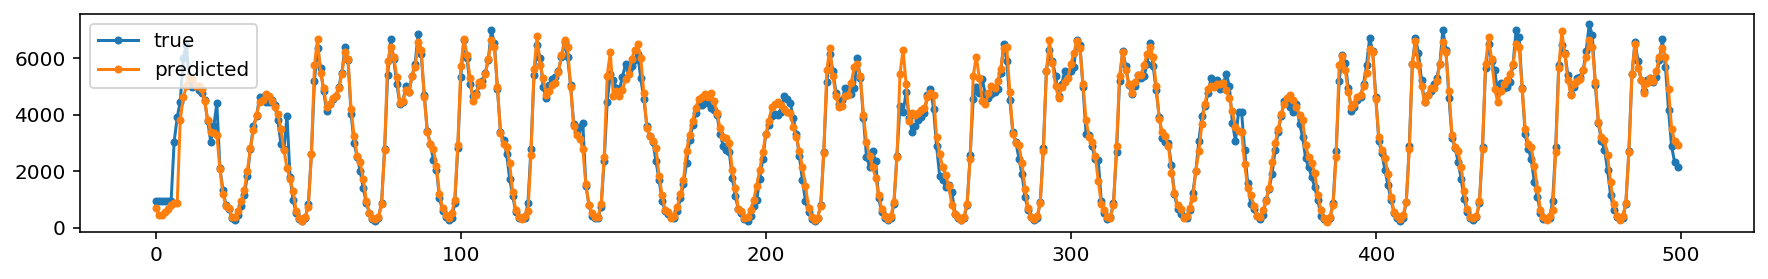

CPU times: user 14min 27s, sys: 1min 14s, total: 15min 42s
Wall time: 14min 14s


In [90]:
%%time
model_label = 'MyLSTM_2'
current_window = my_window1

forward_layer = LSTM(512, return_sequences=True)
backward_layer = LSTM(512, return_sequences=True, go_backwards=True)
 
my_lstm_model = tf.keras.Sequential([
    Bidirectional(forward_layer, backward_layer=backward_layer),
    Bidirectional(LSTM(512, return_sequences=False, stateful=False)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(my_lstm_model, current_window,
                          model_label=model_label, log_dict=my_log,
                          )

In [91]:
my_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 1024)           2211840   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 9,295,361
Trainable params: 9,295,361
Non-trainable params: 0
_________________________________________________________________


#### Model 3



Training vs. Validation:



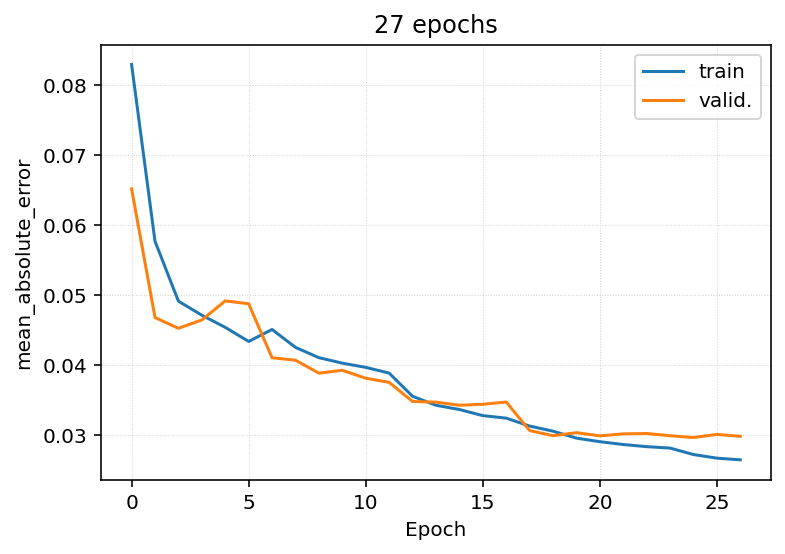



Validation Scores:

261/261 - 1s - loss: 0.0021 - mean_absolute_error: 0.0301


Predictions Evaluation:

Predictions: 8352
MAE: 219.18 (0.0301)


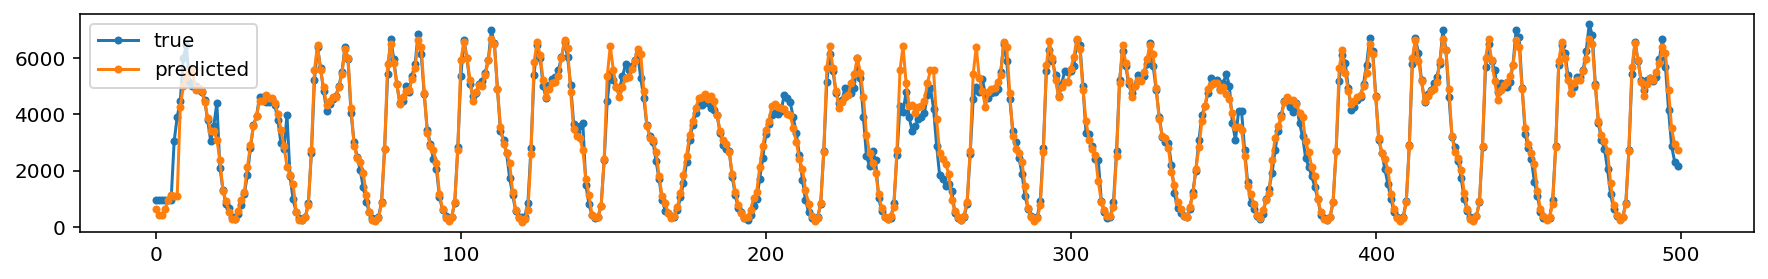

CPU times: user 5min 4s, sys: 34.3 s, total: 5min 38s
Wall time: 4min 22s


In [92]:
%%time
model_label = 'MyLSTM_3'
current_window = my_window1

CONV_WIDTH = 3
my_lstm_model = tf.keras.Sequential([
    GRU(512, return_sequences=True, stateful=False),
    GRU(512, return_sequences=False, stateful=False),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(my_lstm_model, current_window,
                          model_label=model_label, log_dict=my_log,
                          )

In [93]:
my_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6, 512)            830976    
_________________________________________________________________
gru_1 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 2,932,737
Trainable params: 2,932,737
Non-trainable params: 0
_________________________________________________________________


#### Model 4



Training vs. Validation:



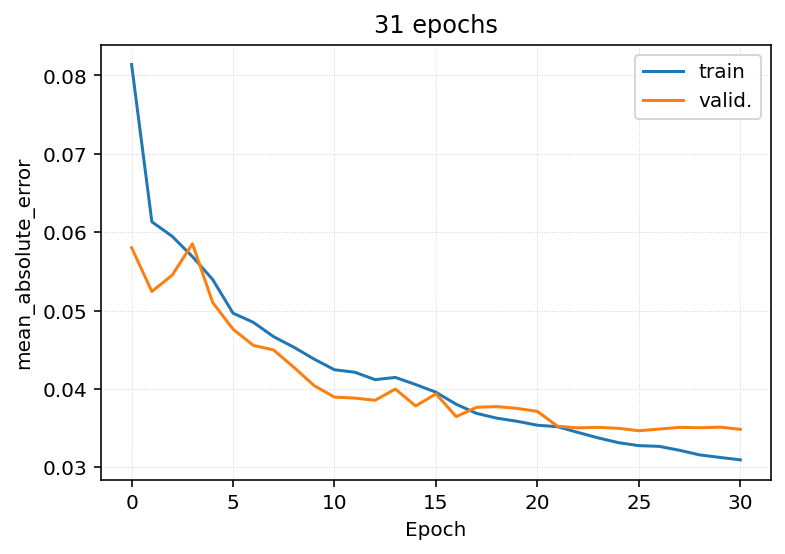



Validation Scores:

261/261 - 1s - loss: 0.0029 - mean_absolute_error: 0.0347


Predictions Evaluation:

Predictions: 8352
MAE: 252.28 (0.0347)


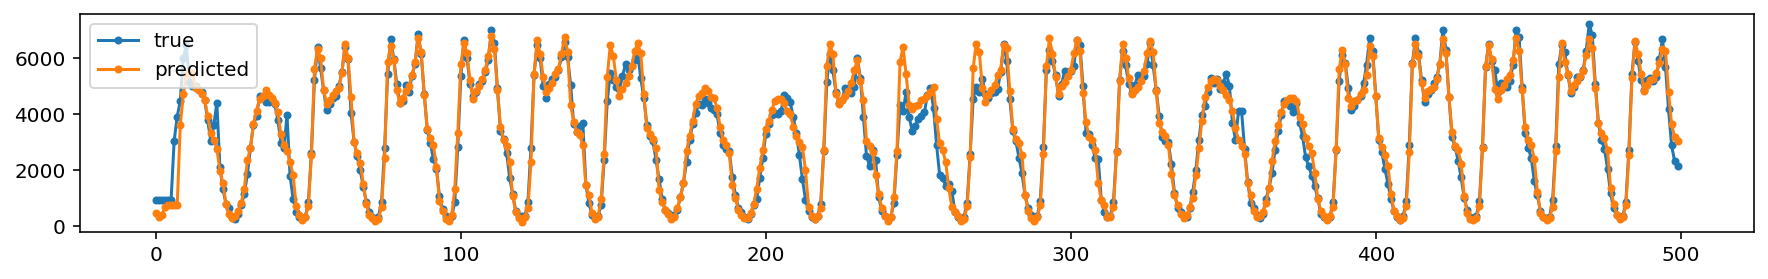

CPU times: user 6min 20s, sys: 44.2 s, total: 7min 4s
Wall time: 5min 11s


In [94]:
%%time
model_label = 'MyLSTM_4'
current_window = my_window1

CONV_WIDTH = 4
my_lstm_model = tf.keras.Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    Conv1D(512, CONV_WIDTH, activation='relu', padding = 'same'),
    MaxPooling1D(pool_size=(2)),
    LSTM(512, return_sequences=True, stateful=False),
    LSTM(512, return_sequences=False, stateful=False),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(my_lstm_model, current_window,
                          model_label=model_label, log_dict=my_log,
                          )

In [95]:
my_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 4, 27)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 512)            55808     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 512)            2099200   
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)              

## Performance Comparison

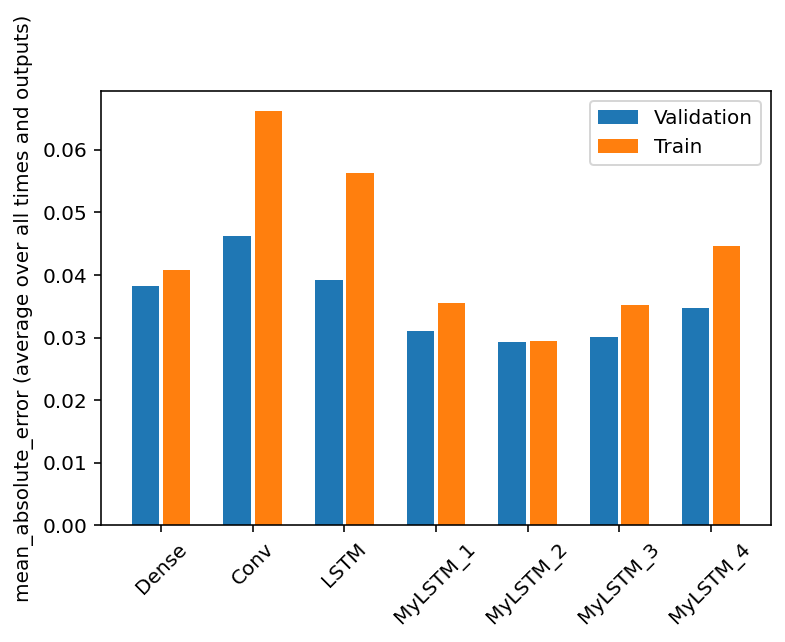

In [96]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = my_lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Train')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'{metric_name} (average over all times and outputs)')
_ = plt.legend()

In [97]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

print()
for name, value in multi_performance.items():
  z = np.float(my_scaler_tv.inverse_transform(np.array([[value[1]]])))
  print(f'{name:8s}: {z:0.4f}')

Dense   : 0.0408
Conv    : 0.0662
LSTM    : 0.0563
MyLSTM_1: 0.0355
MyLSTM_2: 0.0295
MyLSTM_3: 0.0351
MyLSTM_4: 0.0447

Dense   : 296.9976
Conv    : 481.6037
LSTM    : 410.0791
MyLSTM_1: 258.4220
MyLSTM_2: 214.6449
MyLSTM_3: 255.8801
MyLSTM_4: 325.1835


## Generate and Export Test Predictions

In [98]:
final_predictions = my_models['MyLSTM_2'].predict(my_window1.test)
kaggle_predictions = prepare_for_kaggle(final_predictions, test_df, kaggle_df)
export_submission(kaggle_predictions,'submission_maskar.csv')
files.download('/content/submission_maskar.csv')

Required Predictions:	 4993
Clean Predictions:	 4076

Missing Days in Kaggle DF due to records collapse:

	 2018-04-13 23:00:00
	 2018-04-13 23:00:00
	 2018-04-13 23:00:00
	 2018-04-14 00:00:00
	 2018-04-14 00:00:00
	 2018-04-14 01:00:00
	 2018-04-14 01:00:00
	 2018-04-14 01:00:00
	 2018-04-14 02:00:00
	 2018-04-14 02:00:00
	 2018-04-14 02:00:00
	 2018-04-14 03:00:00
	 2018-04-14 03:00:00

Prepared Predictions:	 4993


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>